<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/train_MG_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!make -C sparse_gaussian_elimination a.so

make: Entering directory '/content/sparse_gaussian_elimination'
make: 'a.so' is up to date.
make: Leaving directory '/content/sparse_gaussian_elimination'


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import sparse
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, logsumexp
from network import ScoreNet

#torch.set_default_device('cuda')

# create a.so if doesnt exists
if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
    os.system("make -C ../sparse_gaussian_elimination a.so")


In [3]:
# download mnist dataset
mnist = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
mnist_data = mnist.data[mnist.targets == 5] # grab the fives

# sample 5 images for training
mnist_data = mnist_data[np.random.choice(list(range(len(mnist_data))), 5, replace=False)]
#mnist_data = mnist_data[[100, 101]]
# mnist_data = np.moveaxis(mnist.data.numpy(), 0, -1)
# mnist_data.shape
#mnist_data = np.array(mnist)


In [4]:
## construct the grid and Initial values
batch_size = 32
N = 10
H = 28
W = 28
epoch = 30
eps = 1e-6

t = np.linspace(eps, 1, N)

sigma = 25 #* np.linspace(1, len(mnist_data) + 1, len(mnist_data))
# create model
loss_fn = torch.nn.MSELoss()
mm_scaler = MinMaxScaler()
model_score = ScoreNet(H=H, W=W)
model_score.train()
optimizer = Adam(model_score.parameters(), lr=1e-3)

  0%|          | 0/30 [00:00<?, ?it/s]

tensor(132.7632) tensor(-109.8117)


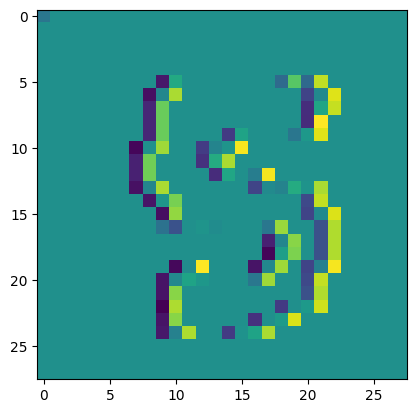

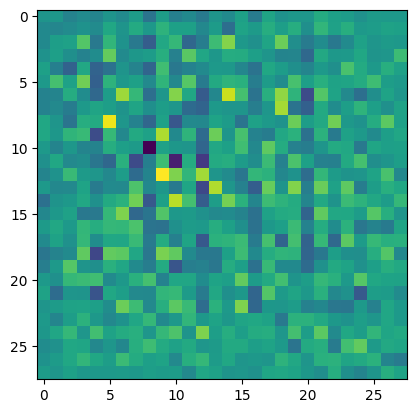

tensor(2326.6047) tensor(-2618.1086)


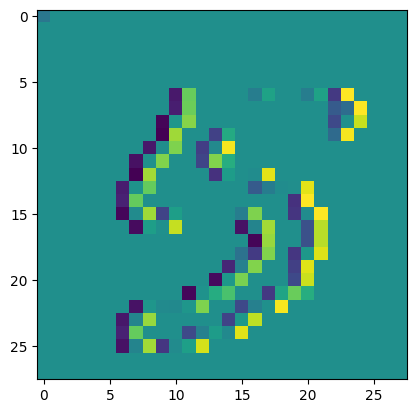

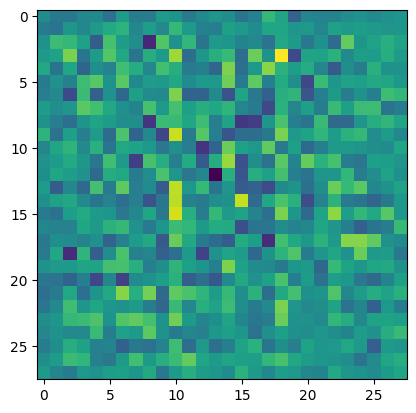

tensor(65921.6250) tensor(-65047.8516)


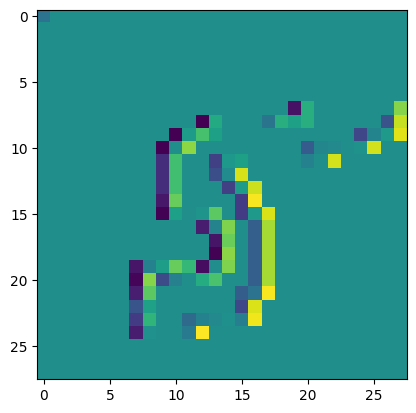

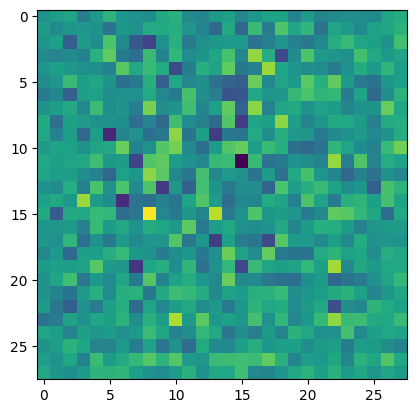

tensor(1983106.7500) tensor(-1753604.7500)


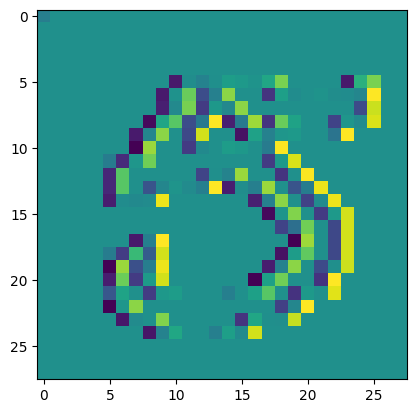

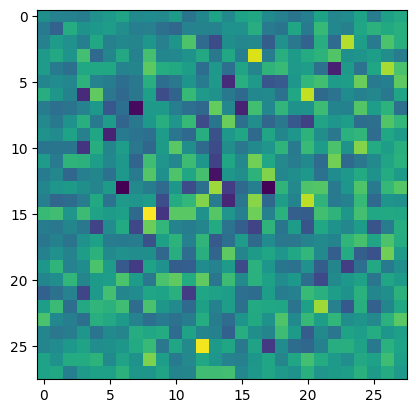

tensor(53514848.) tensor(-41627360.)


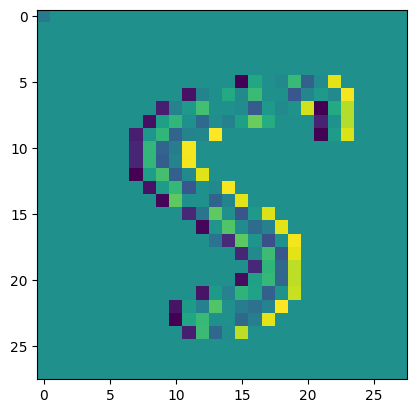

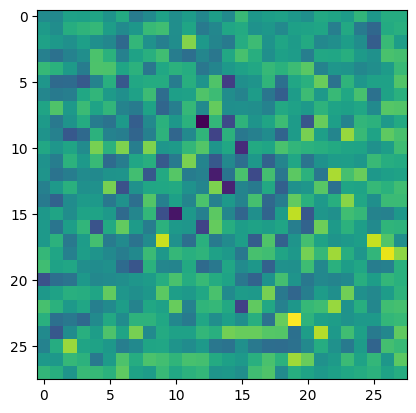

  3%|▎         | 1/30 [00:23<11:27, 23.71s/it]

tensor(98.2015) tensor(-105.1389)


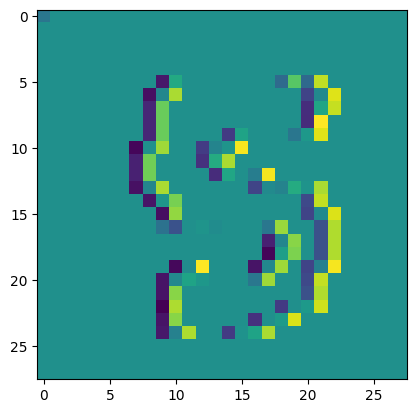

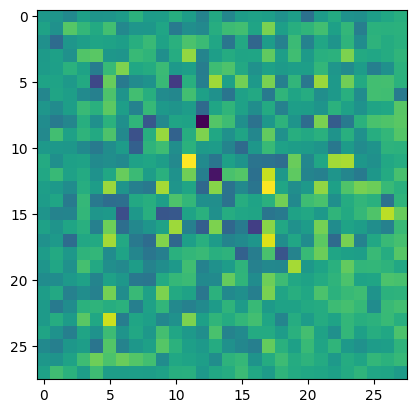

tensor(2769.1941) tensor(-2768.1670)


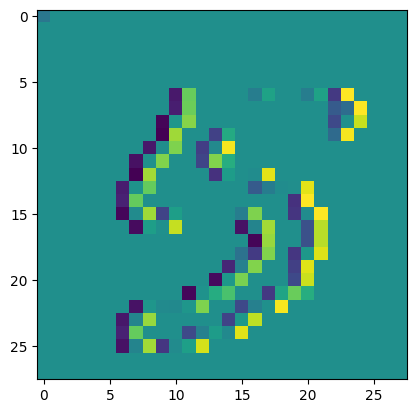

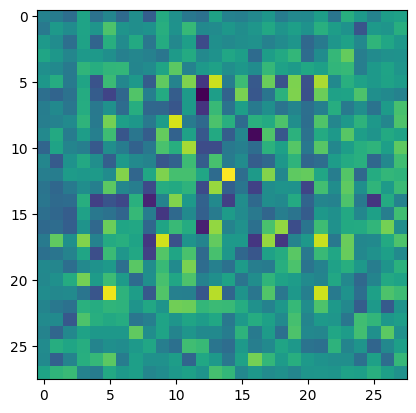

tensor(58207.2539) tensor(-64950.9766)


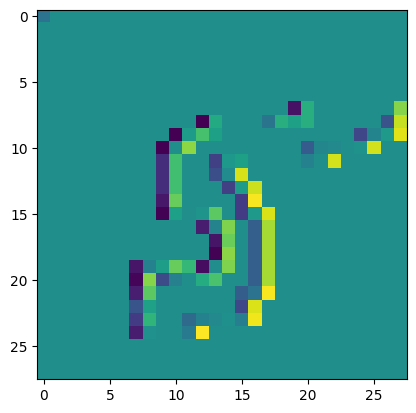

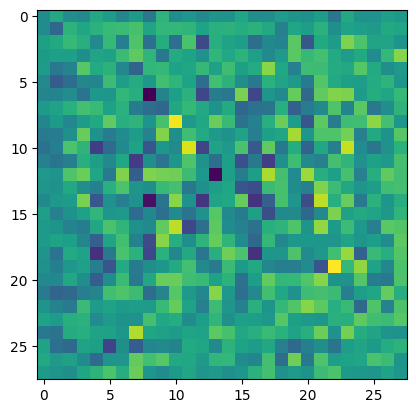

tensor(1671570.) tensor(-1804858.)


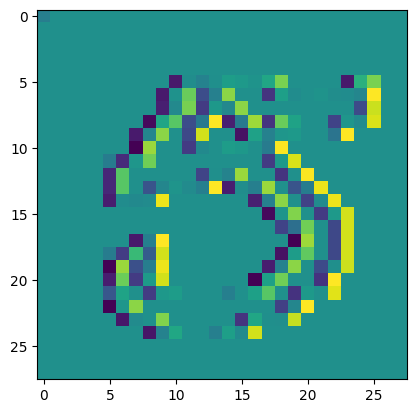

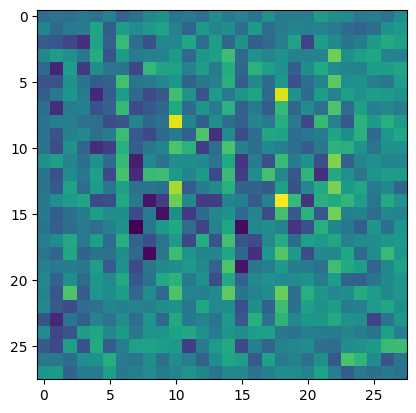

tensor(36235856.) tensor(-37704584.)


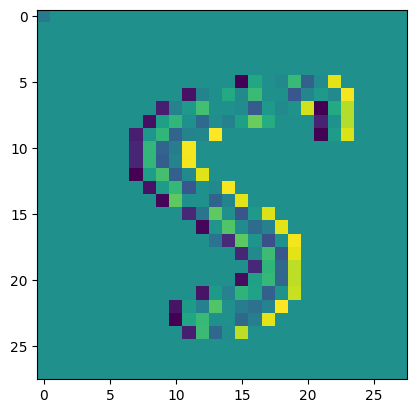

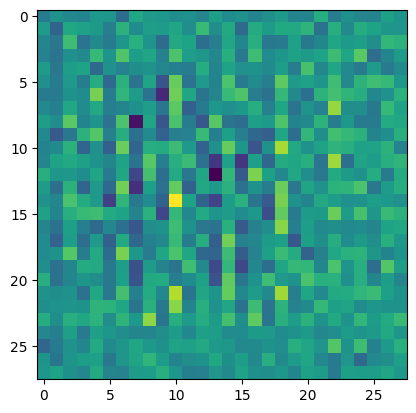

  7%|▋         | 2/30 [00:43<09:55, 21.27s/it]

tensor(127.5287) tensor(-137.4723)


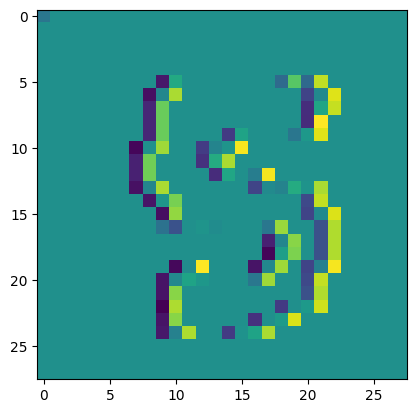

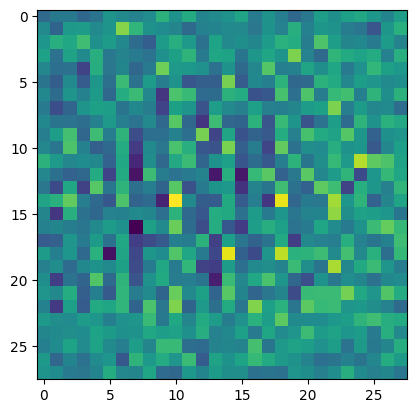

tensor(2673.0208) tensor(-2894.5083)


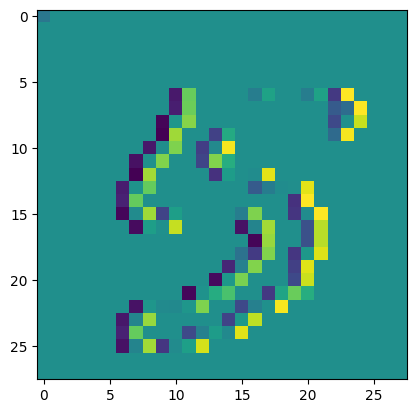

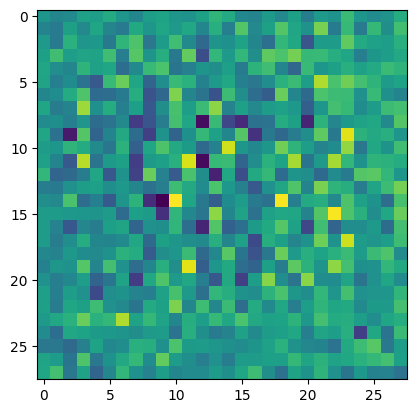

tensor(61906.3477) tensor(-68648.8594)


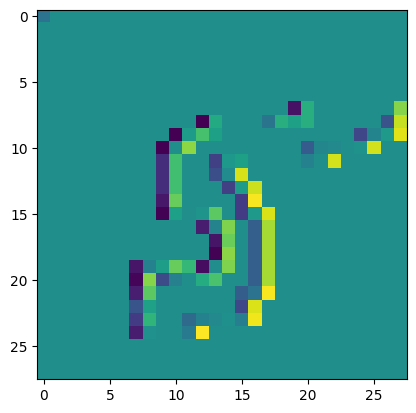

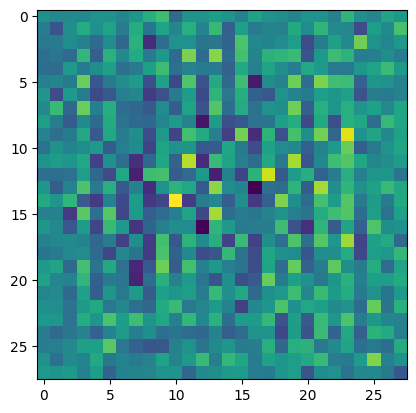

tensor(1706560.3750) tensor(-1691689.6250)


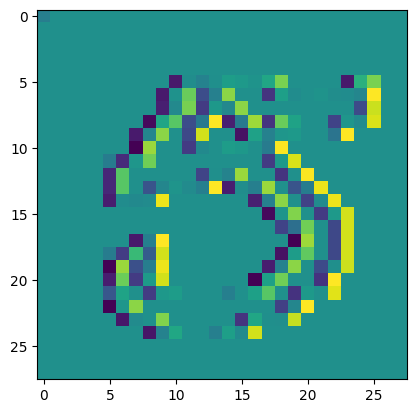

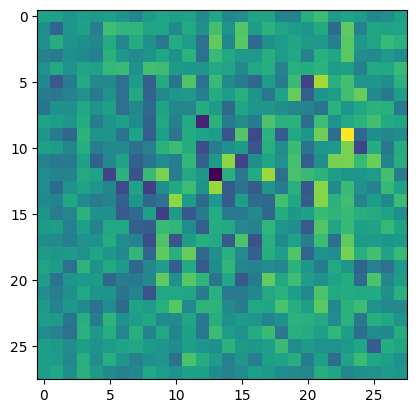

tensor(45220148.) tensor(-53789264.)


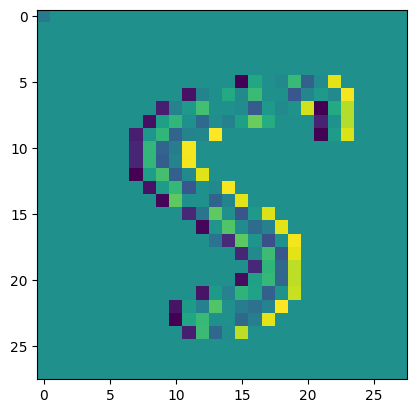

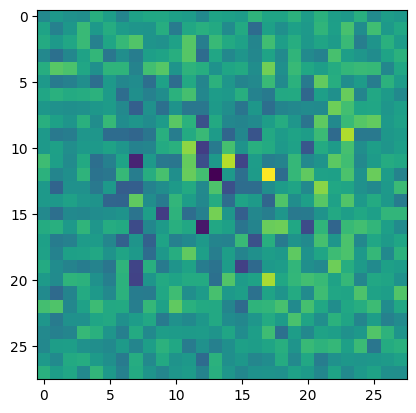

 10%|█         | 3/30 [01:03<09:23, 20.88s/it]

tensor(119.4146) tensor(-144.8707)


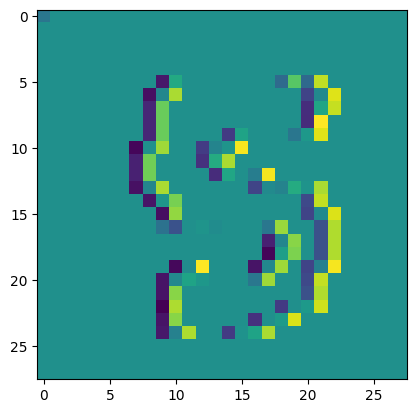

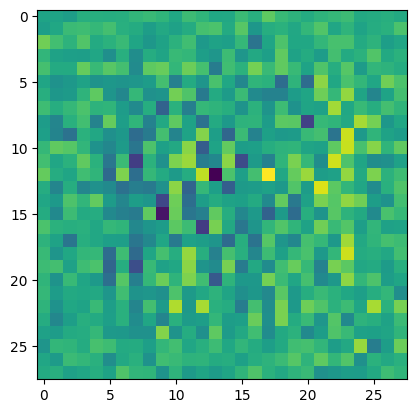

tensor(2828.1853) tensor(-3102.0361)


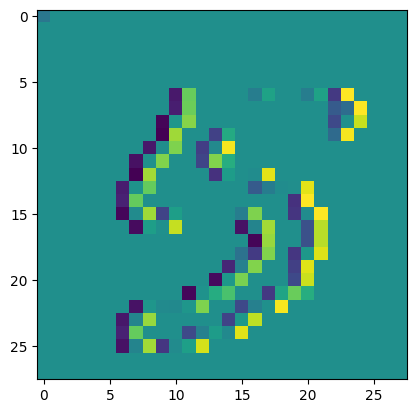

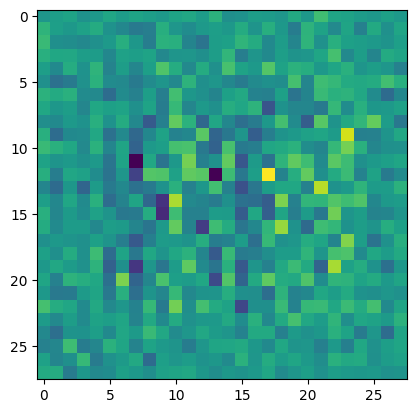

tensor(64508.6836) tensor(-67236.3984)


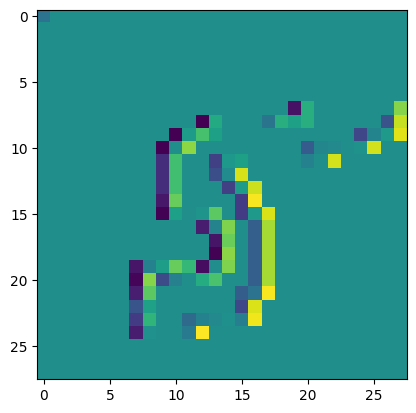

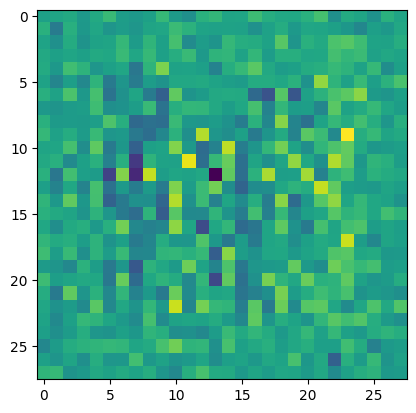

tensor(1539086.7500) tensor(-2393323.)


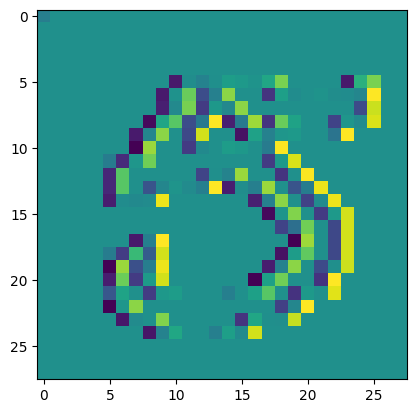

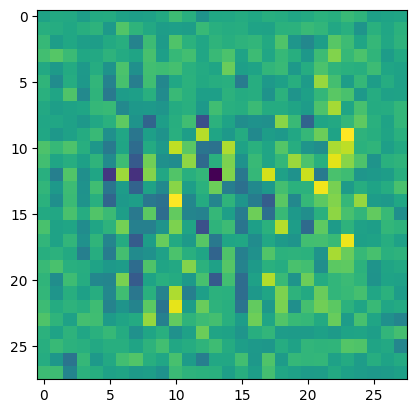

tensor(40009708.) tensor(-38012928.)


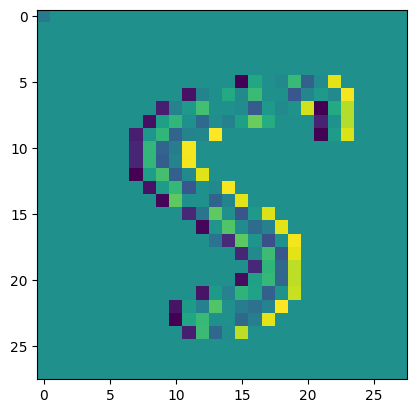

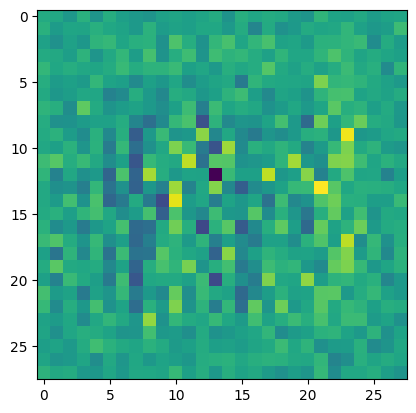

 13%|█▎        | 4/30 [01:23<08:49, 20.38s/it]

tensor(112.4337) tensor(-109.0821)


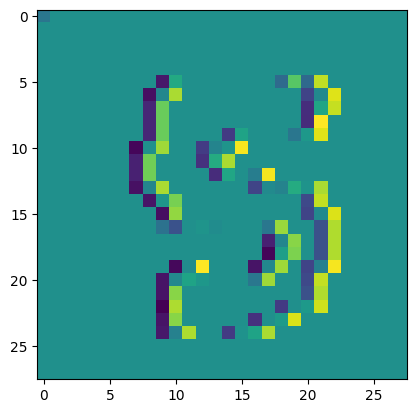

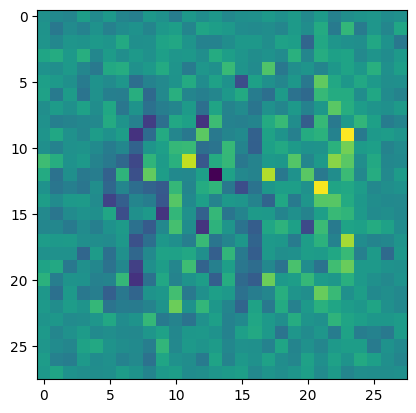

tensor(2543.8621) tensor(-3023.3228)


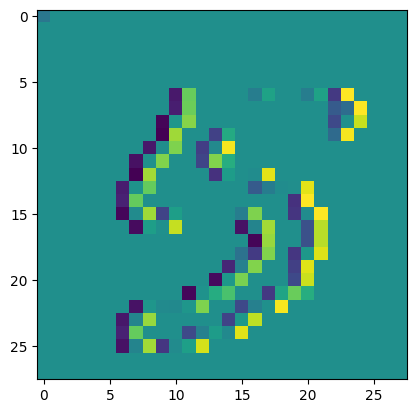

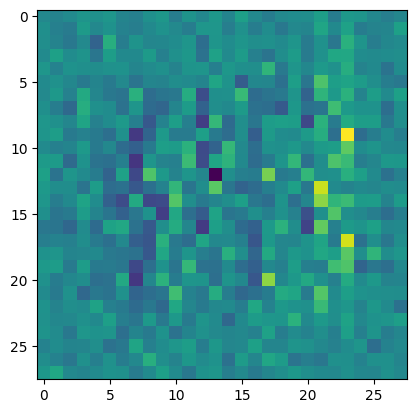

tensor(66639.2734) tensor(-74699.)


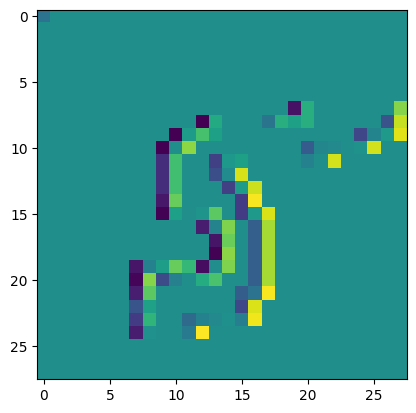

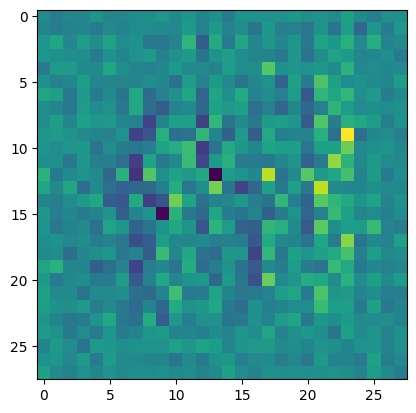

tensor(1519834.7500) tensor(-2171478.5000)


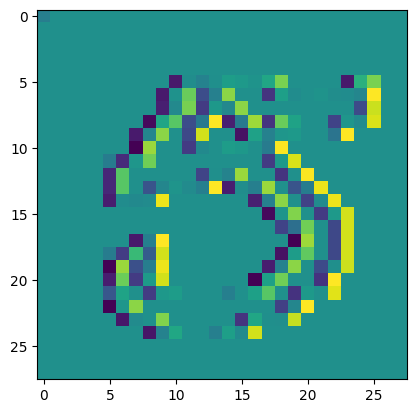

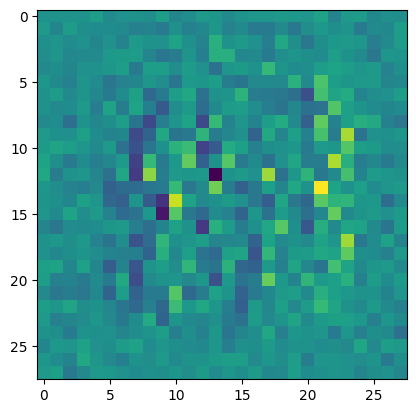

tensor(45644804.) tensor(-39658432.)


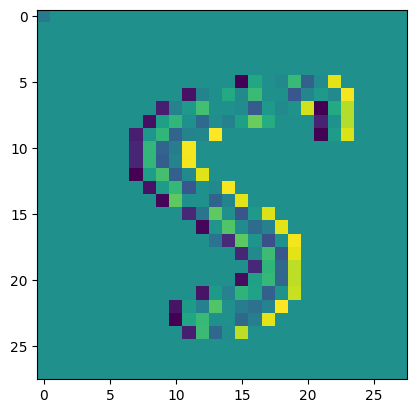

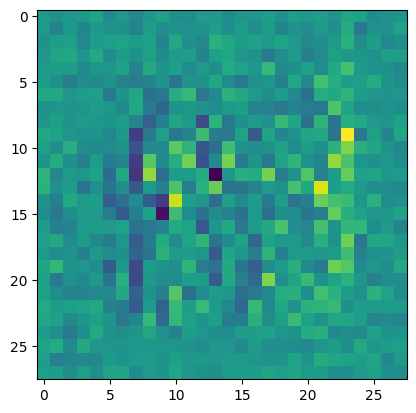

 17%|█▋        | 5/30 [01:43<08:26, 20.26s/it]

tensor(98.0511) tensor(-100.5860)


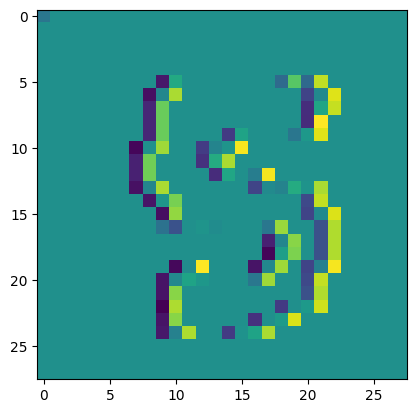

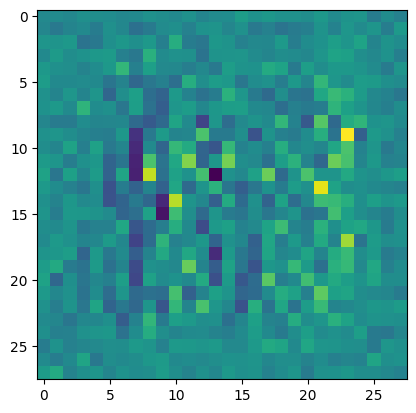

tensor(2552.4143) tensor(-2990.0764)


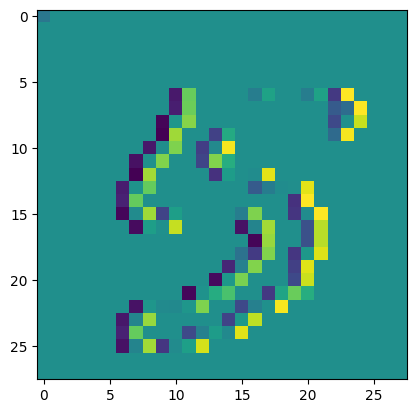

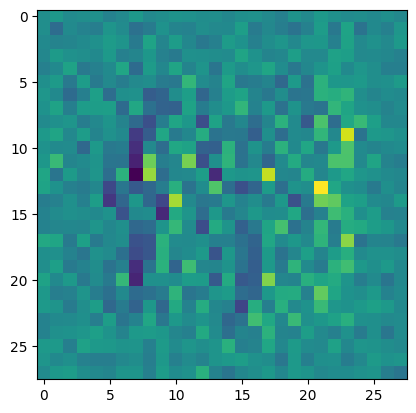

tensor(69501.7656) tensor(-57301.1211)


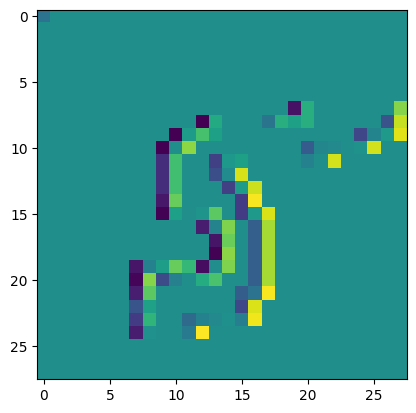

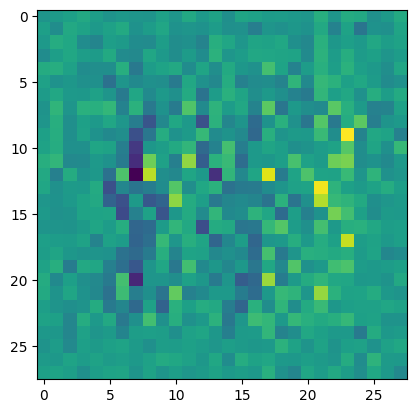

tensor(2041410.3750) tensor(-1620436.6250)


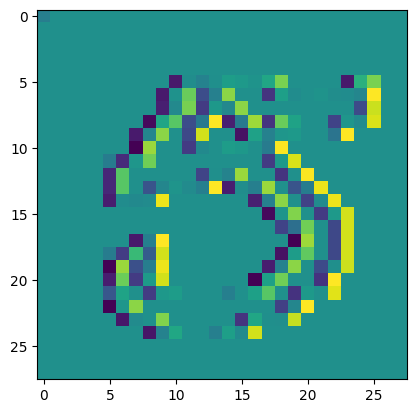

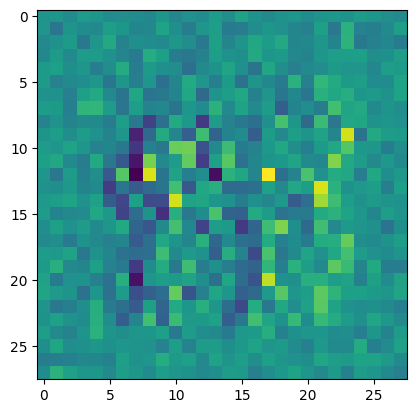

tensor(40032256.) tensor(-44764824.)


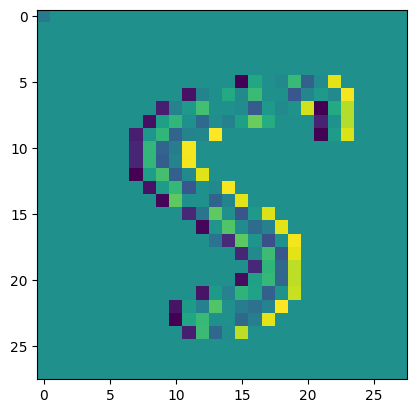

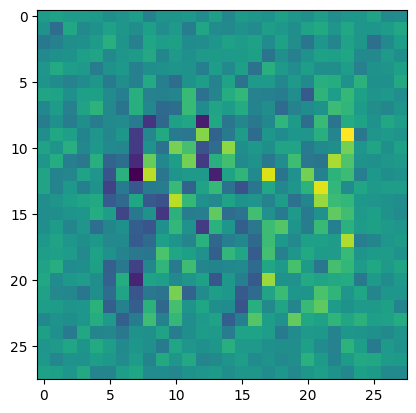

 20%|██        | 6/30 [02:03<08:08, 20.35s/it]

tensor(114.3226) tensor(-102.9404)


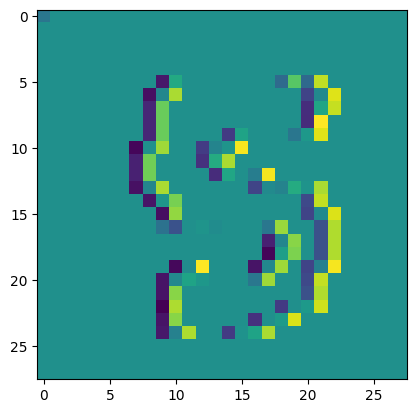

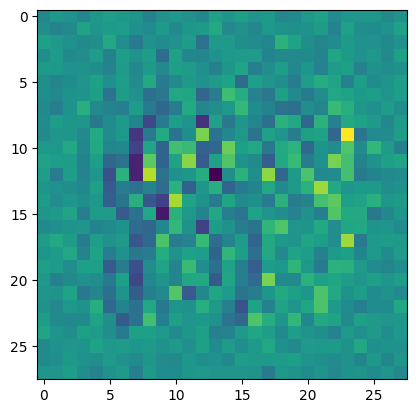

tensor(2619.9551) tensor(-2946.4124)


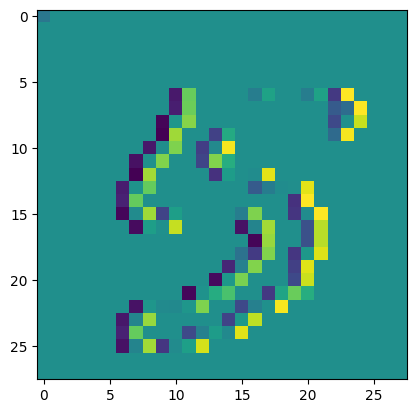

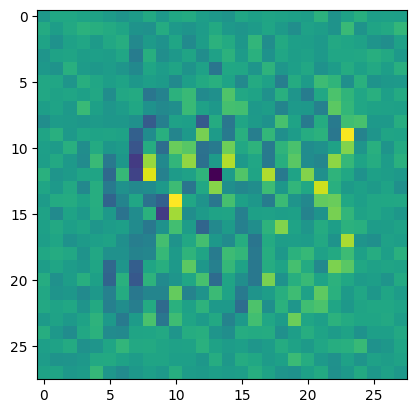

tensor(63419.4102) tensor(-66159.5078)


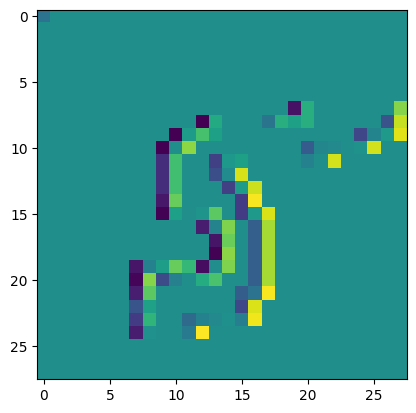

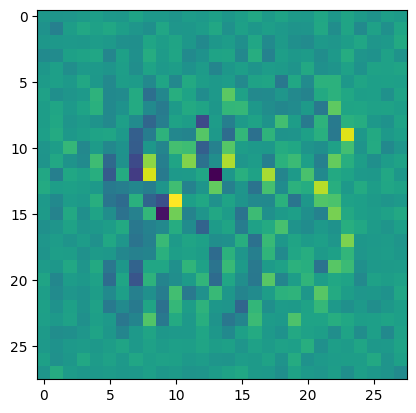

tensor(1530721.) tensor(-1921760.3750)


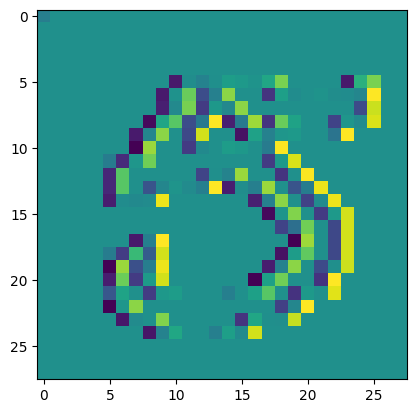

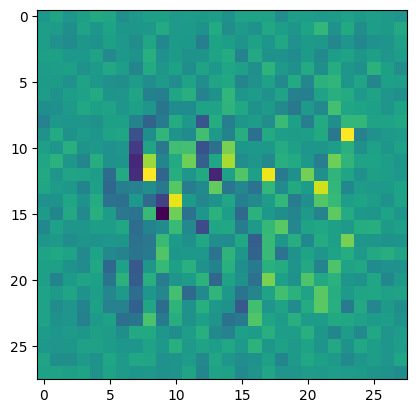

tensor(44532652.) tensor(-41064752.)


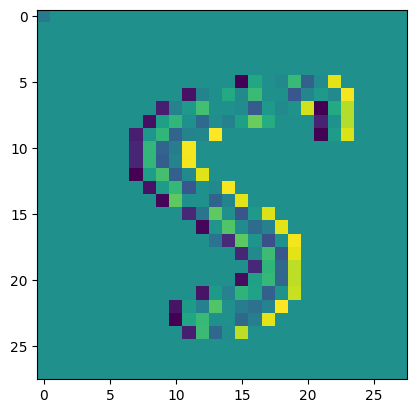

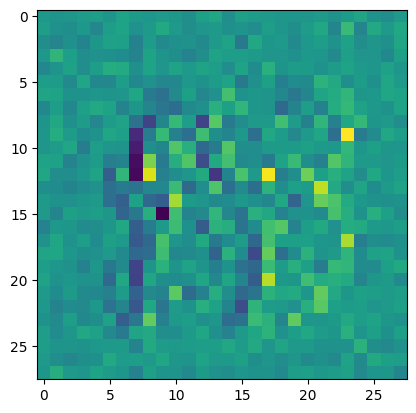

 23%|██▎       | 7/30 [02:23<07:41, 20.07s/it]

tensor(102.2725) tensor(-100.1614)


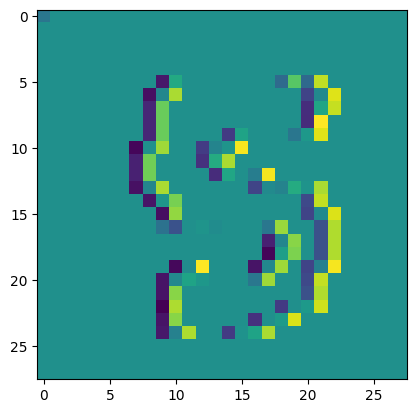

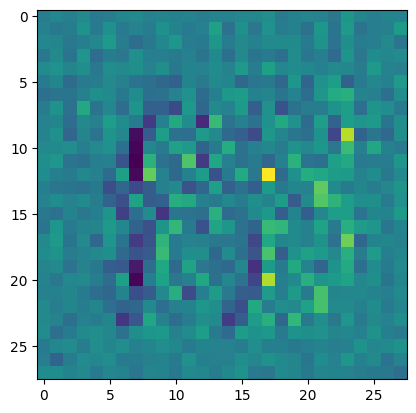

tensor(2855.5410) tensor(-2856.8181)


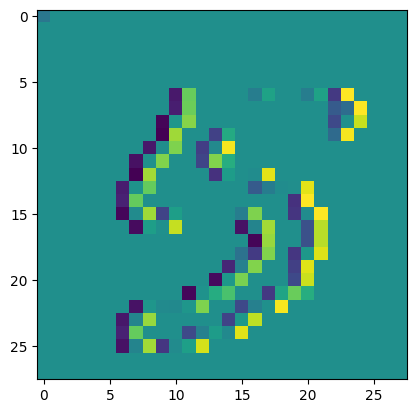

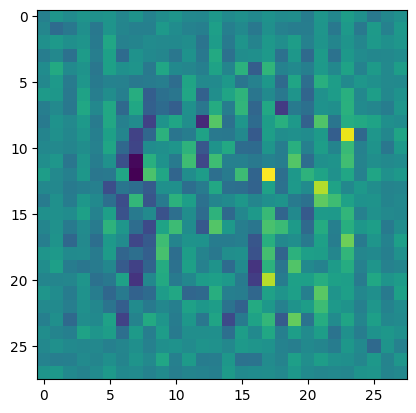

tensor(61574.1250) tensor(-66064.0156)


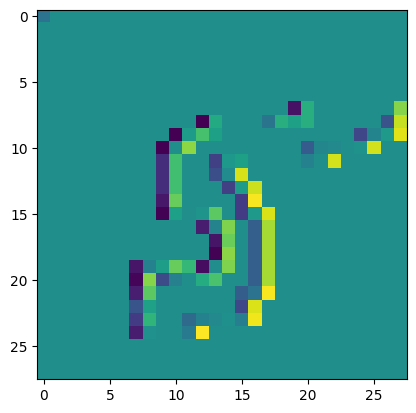

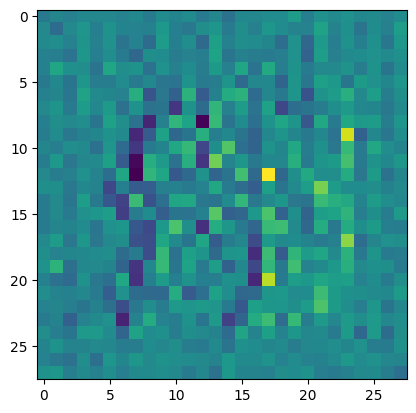

tensor(1580742.) tensor(-1753067.8750)


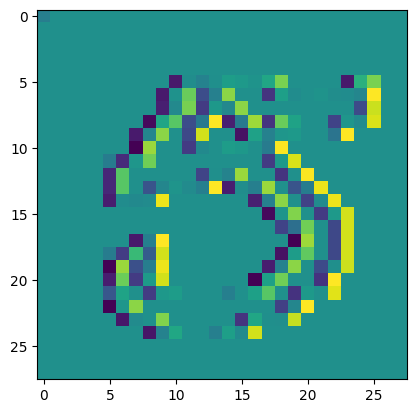

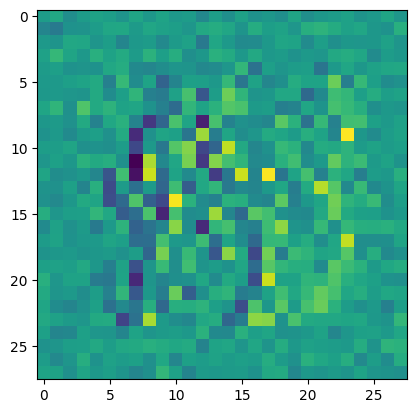

tensor(42132036.) tensor(-47575868.)


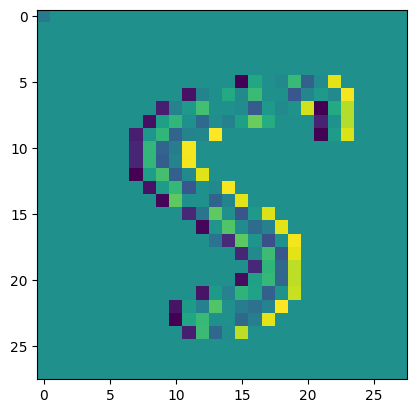

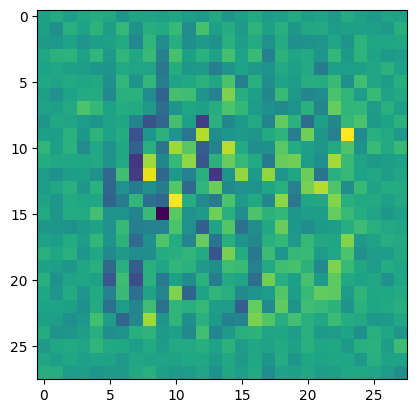

 27%|██▋       | 8/30 [02:43<07:24, 20.22s/it]

tensor(112.8014) tensor(-120.1085)


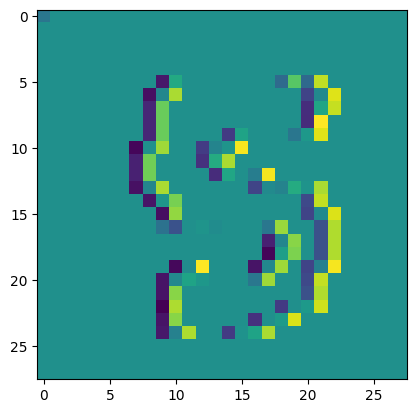

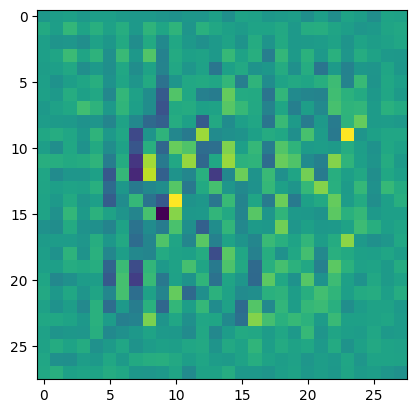

tensor(2926.6956) tensor(-2731.6431)


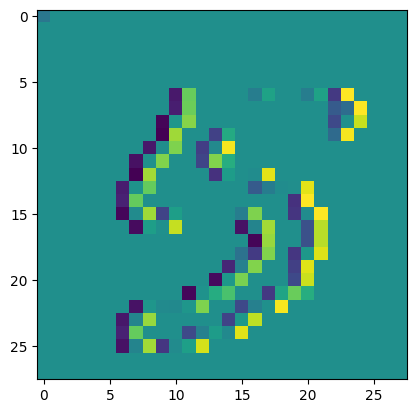

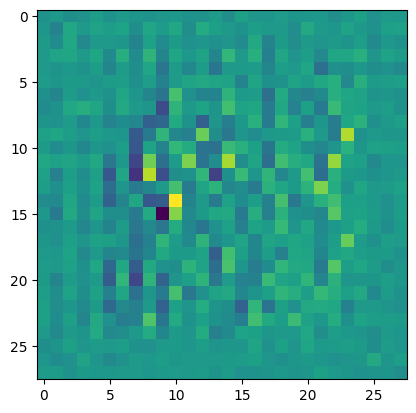

tensor(72968.4531) tensor(-76571.0781)


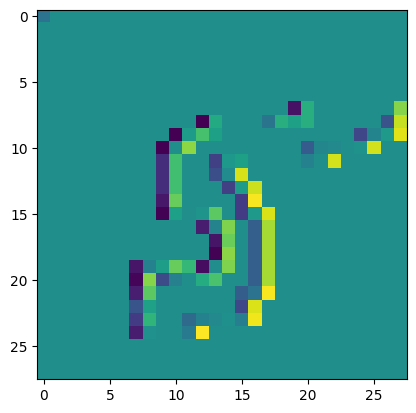

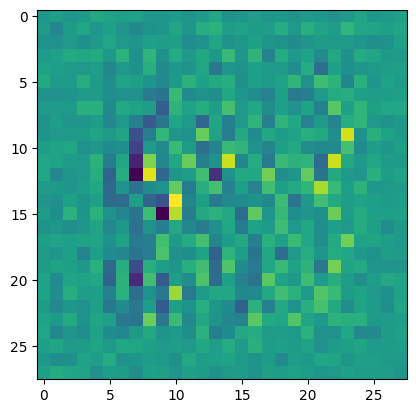

tensor(1620780.) tensor(-1672455.)


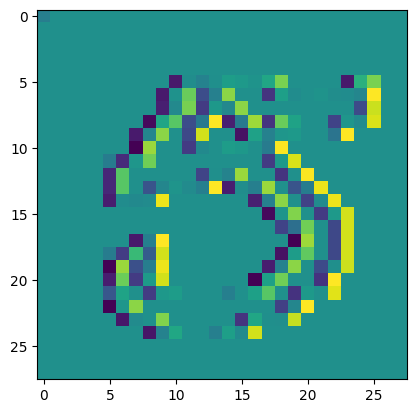

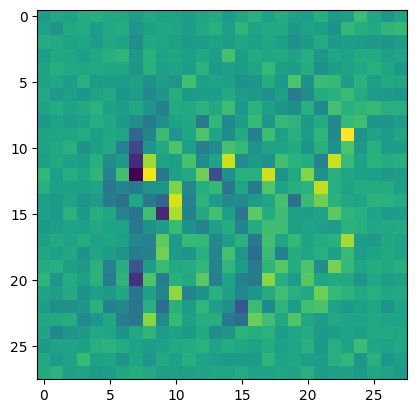

tensor(43178280.) tensor(-40299544.)


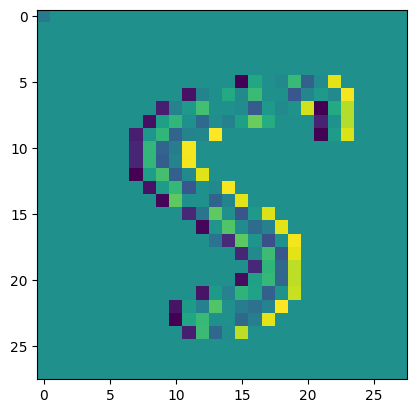

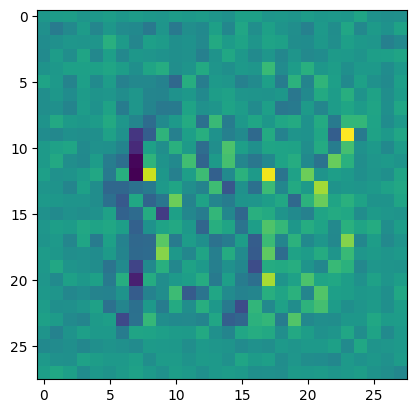

 30%|███       | 9/30 [03:04<07:05, 20.26s/it]

tensor(141.0818) tensor(-114.3767)


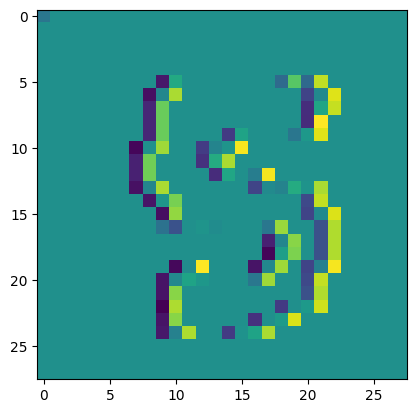

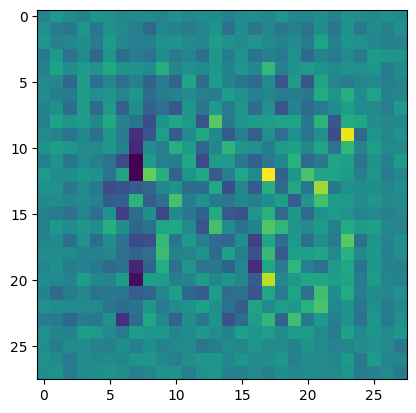

tensor(3112.2612) tensor(-2679.5933)


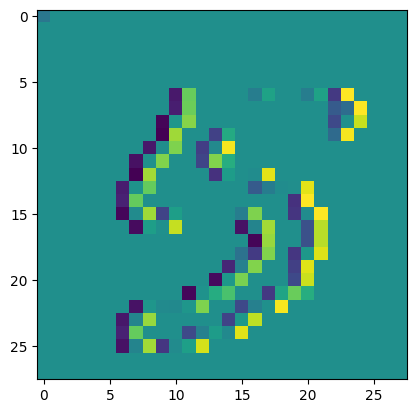

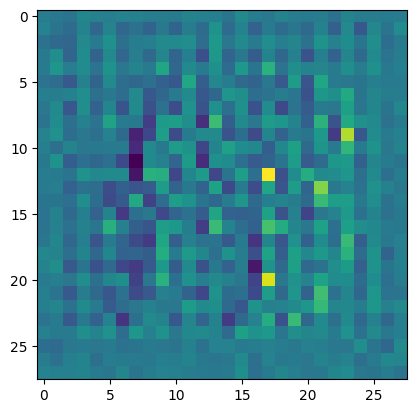

tensor(63600.0703) tensor(-65813.8750)


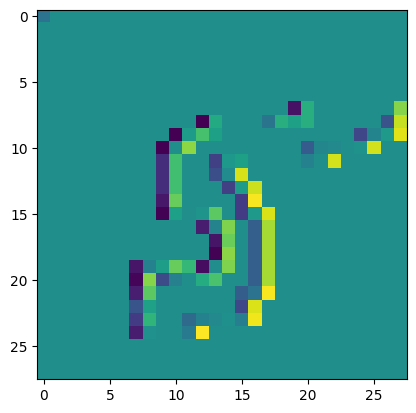

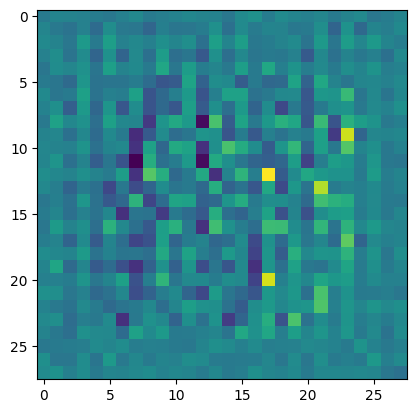

tensor(1925164.) tensor(-1927956.5000)


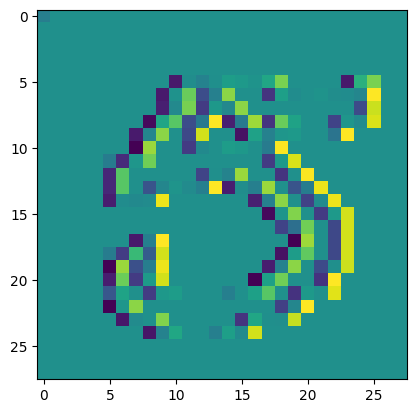

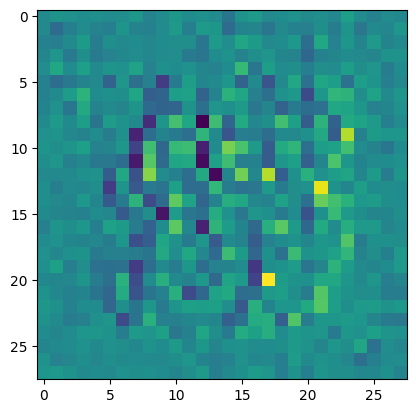

tensor(52814324.) tensor(-45194024.)


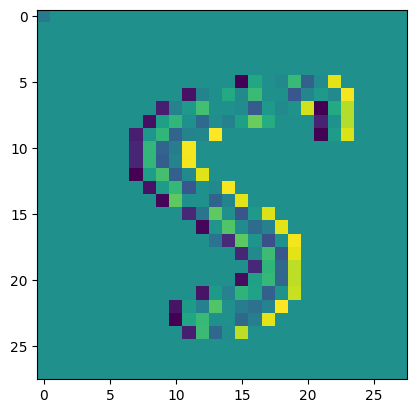

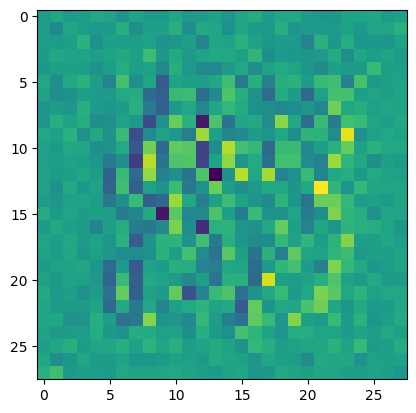

 33%|███▎      | 10/30 [03:24<06:42, 20.12s/it]

tensor(107.6670) tensor(-96.8220)


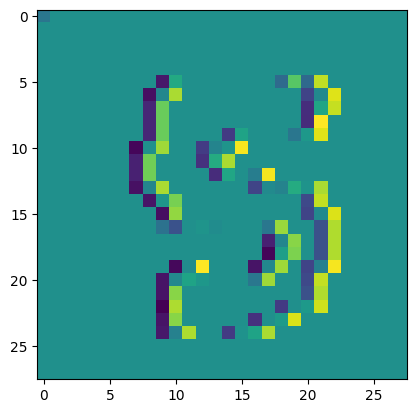

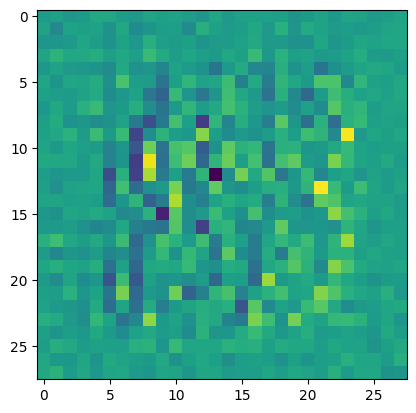

tensor(3020.3076) tensor(-2909.8137)


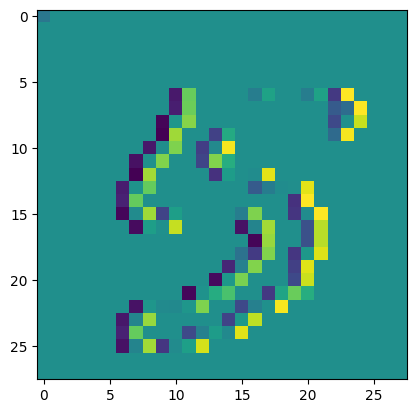

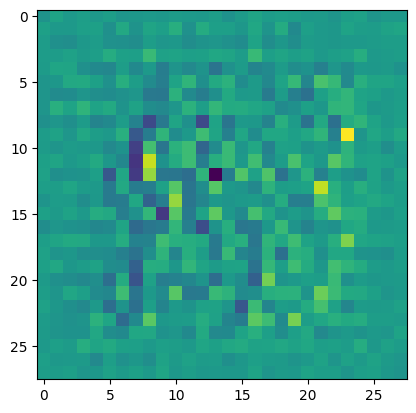

tensor(82462.5938) tensor(-60255.0391)


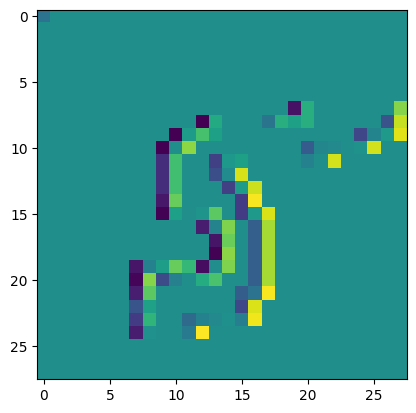

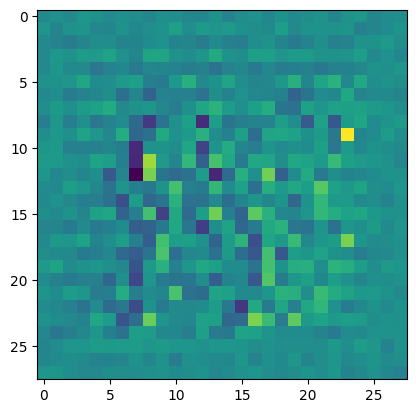

tensor(2110873.5000) tensor(-1432052.2500)


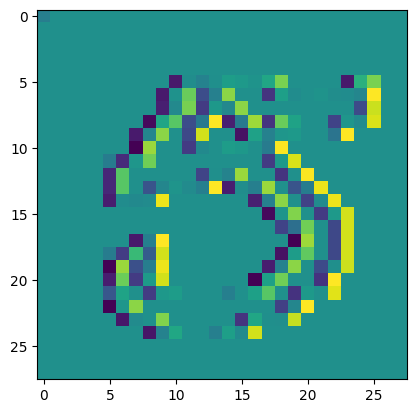

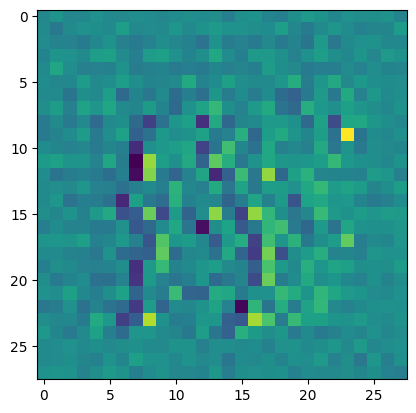

tensor(39594896.) tensor(-48671600.)


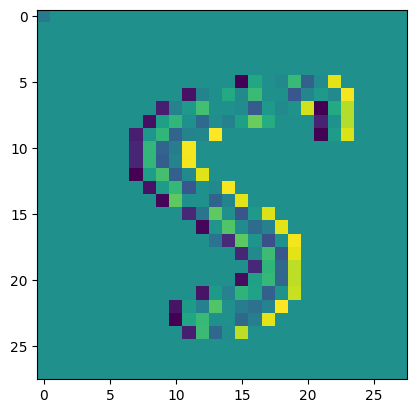

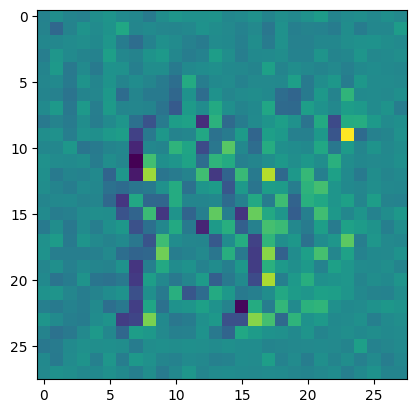

 37%|███▋      | 11/30 [03:44<06:24, 20.22s/it]

tensor(129.3915) tensor(-104.9316)


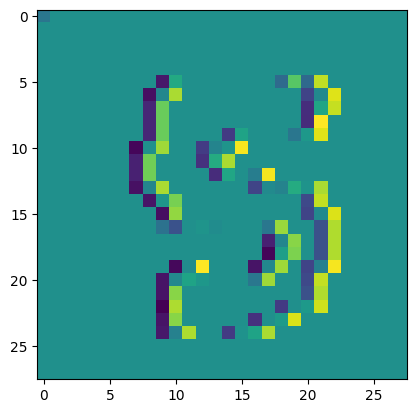

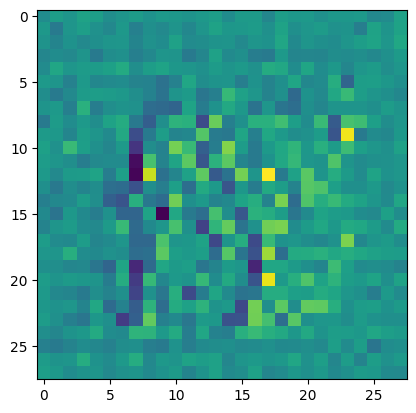

tensor(2389.1223) tensor(-2657.8606)


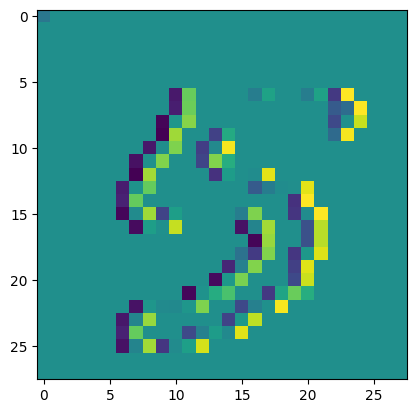

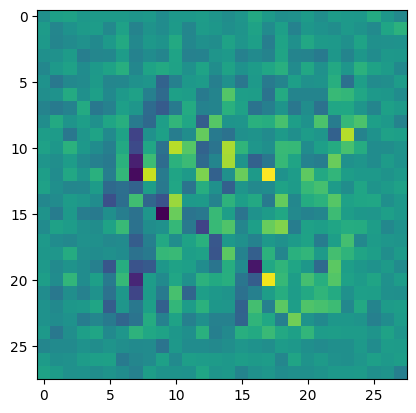

tensor(63346.0938) tensor(-82265.5312)


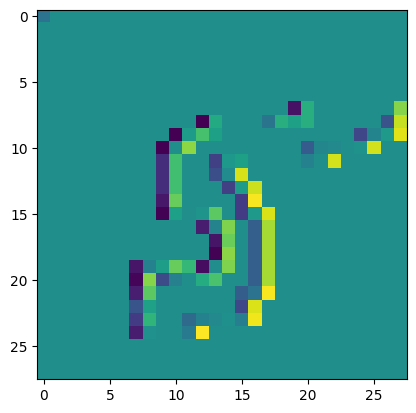

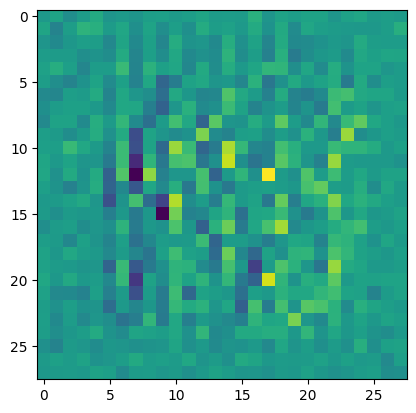

tensor(1760683.2500) tensor(-1615921.6250)


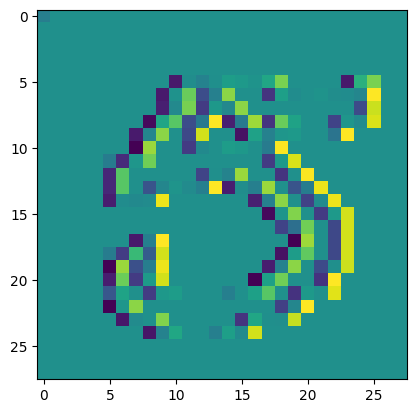

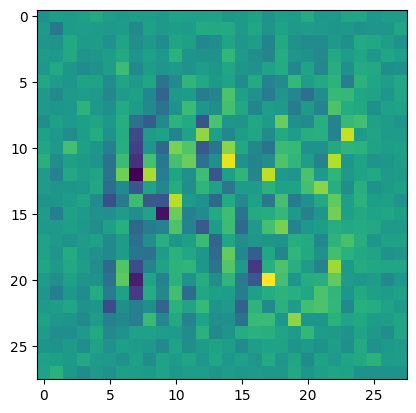

tensor(39059940.) tensor(-39690564.)


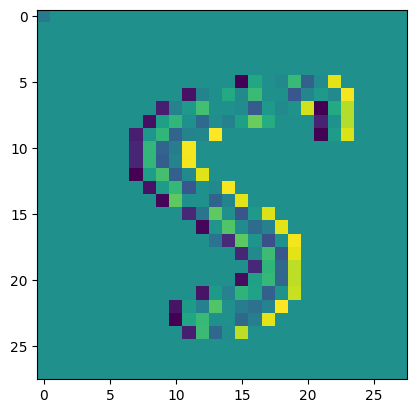

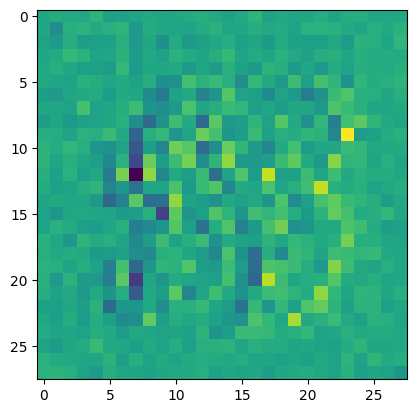

 40%|████      | 12/30 [04:04<06:00, 20.04s/it]

tensor(113.3221) tensor(-118.1058)


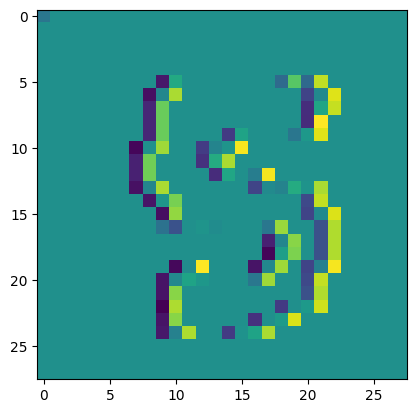

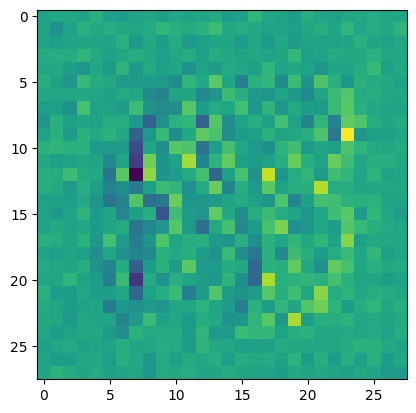

tensor(3277.5339) tensor(-2373.9121)


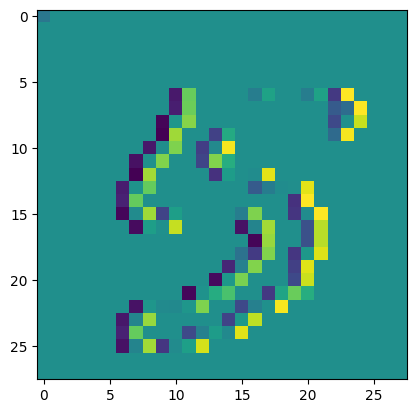

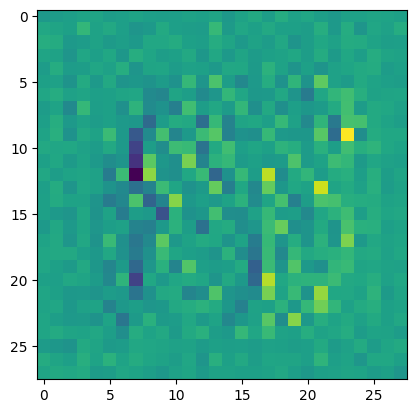

tensor(68071.0312) tensor(-98203.9766)


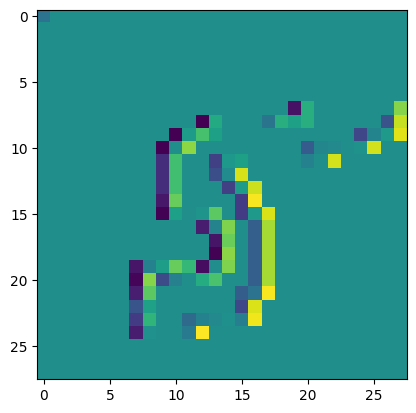

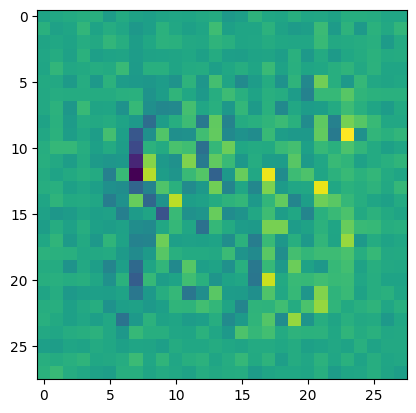

tensor(1899281.6250) tensor(-1651056.6250)


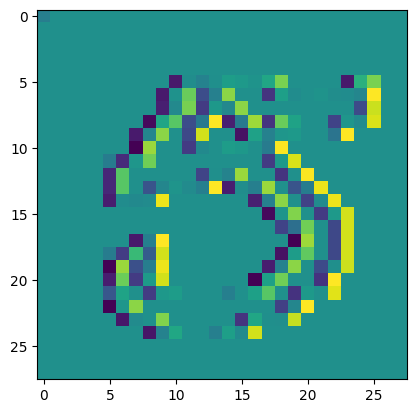

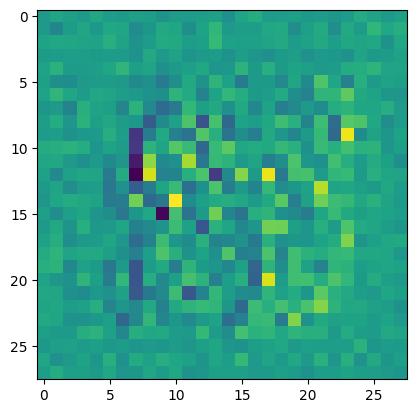

tensor(38227780.) tensor(-48555828.)


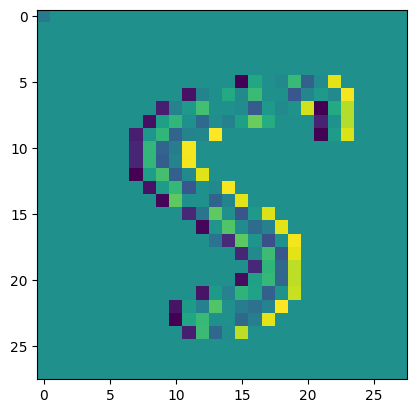

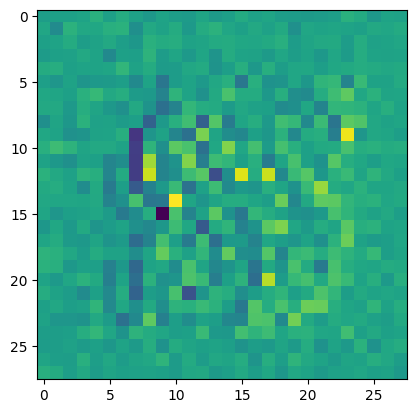

 43%|████▎     | 13/30 [04:25<05:47, 20.43s/it]

tensor(94.8042) tensor(-109.9997)


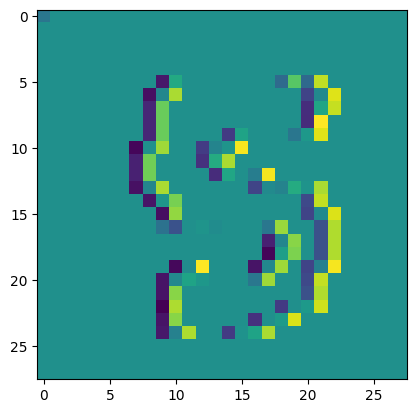

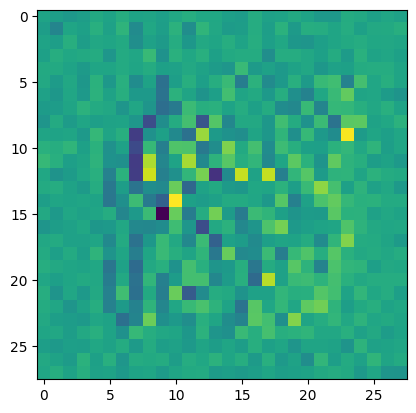

tensor(2434.5369) tensor(-2836.6118)


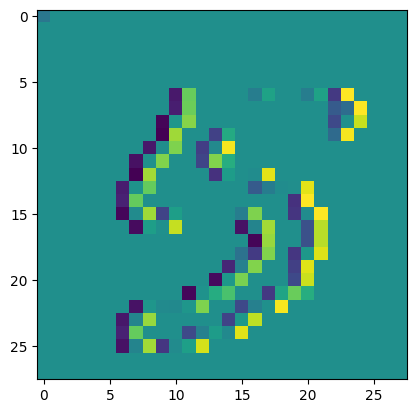

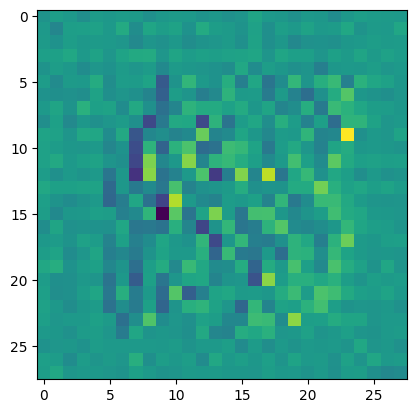

tensor(71232.5156) tensor(-81432.6641)


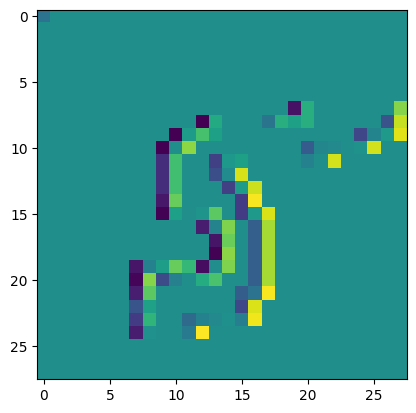

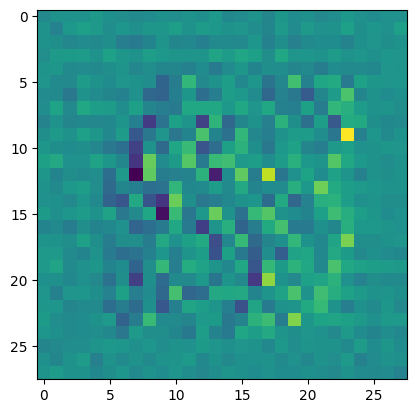

tensor(1584457.5000) tensor(-1677682.2500)


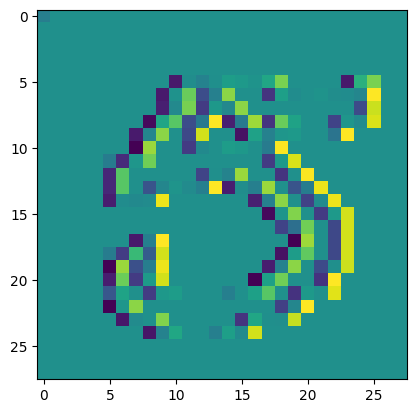

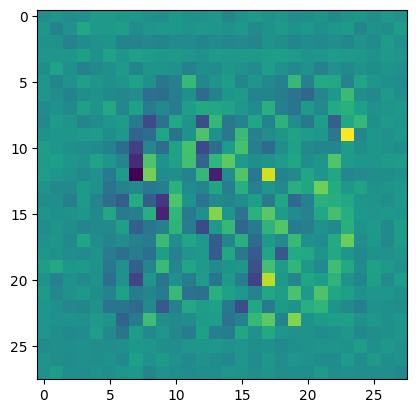

tensor(50440532.) tensor(-45600436.)


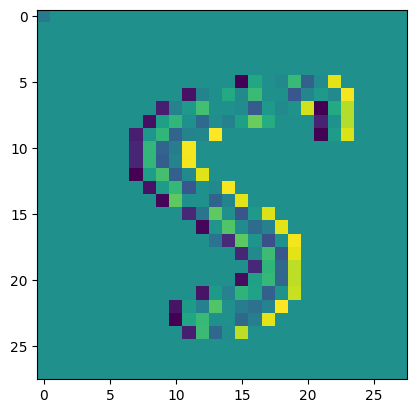

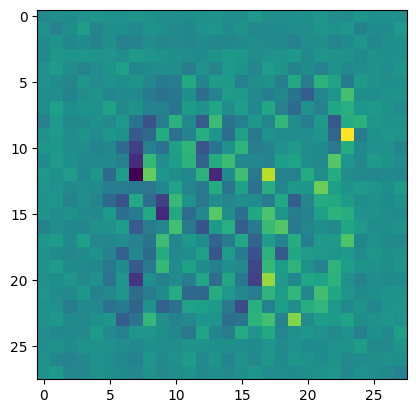

 47%|████▋     | 14/30 [04:45<05:25, 20.37s/it]

tensor(117.0811) tensor(-93.0819)


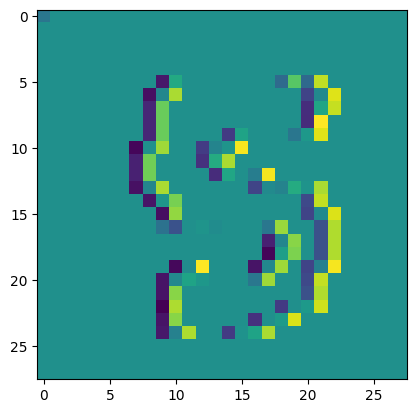

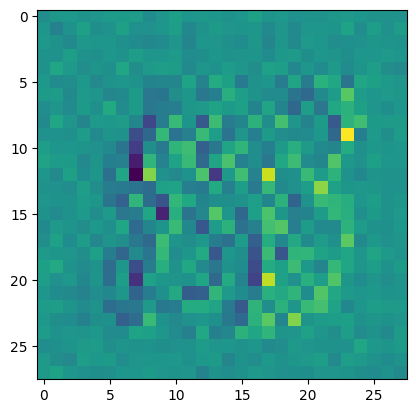

tensor(3185.7454) tensor(-2811.5381)


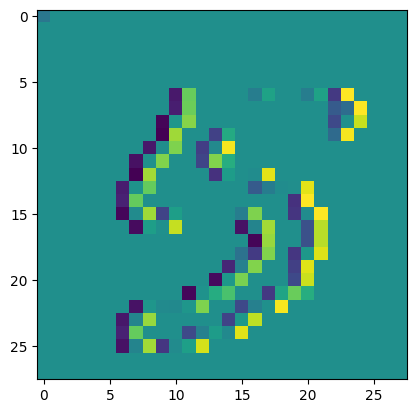

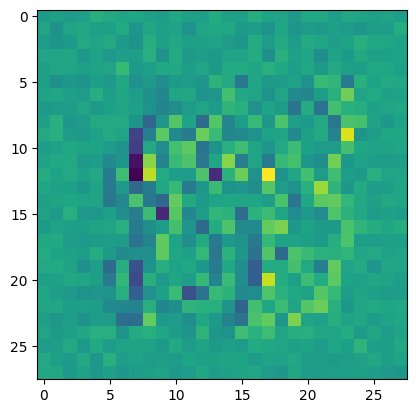

tensor(65616.3750) tensor(-61640.3008)


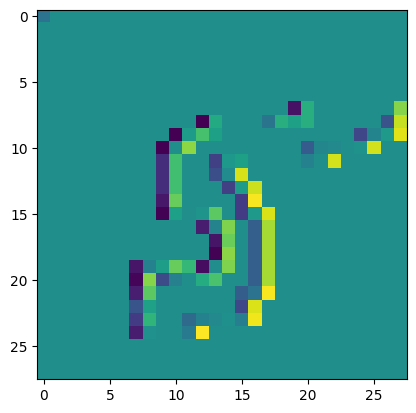

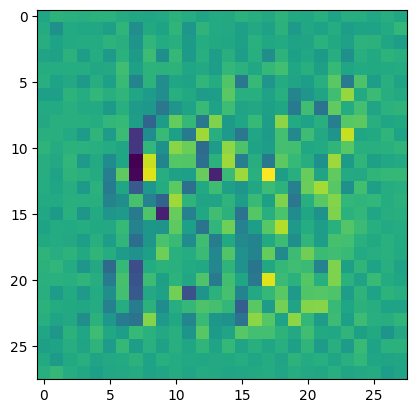

tensor(1651666.) tensor(-1522841.8750)


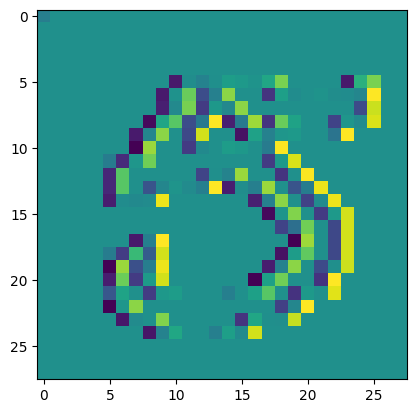

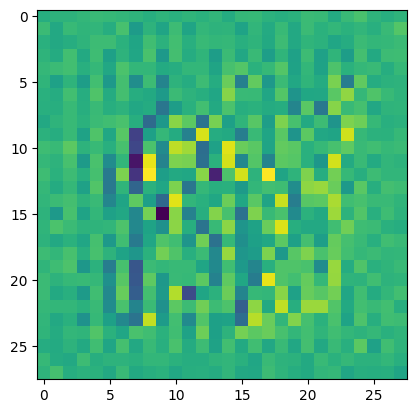

tensor(42013852.) tensor(-38458852.)


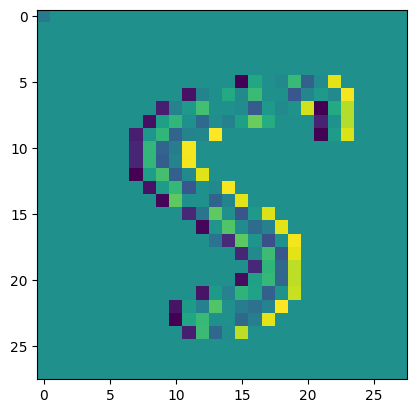

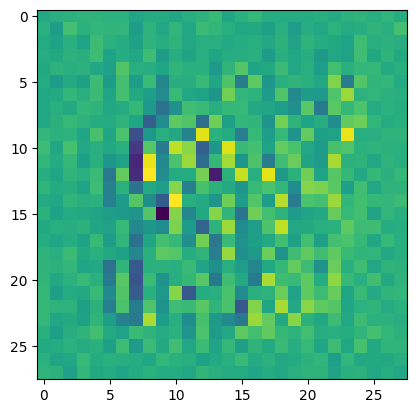

 50%|█████     | 15/30 [05:05<05:02, 20.16s/it]

tensor(109.6513) tensor(-112.6438)


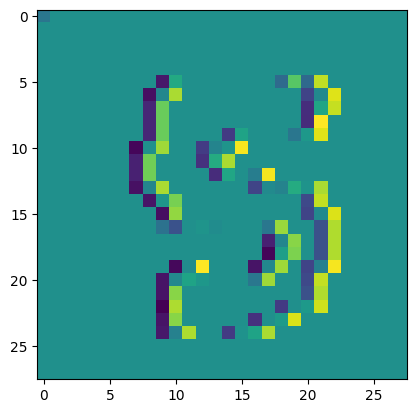

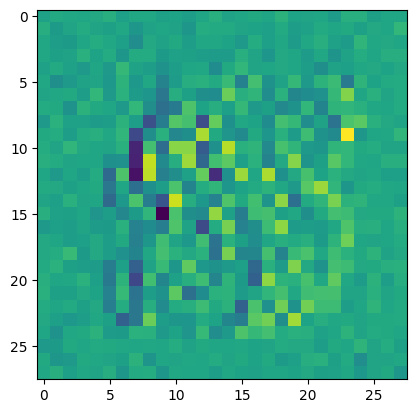

tensor(2986.7852) tensor(-3090.7473)


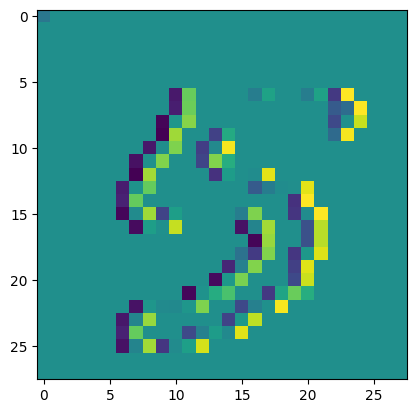

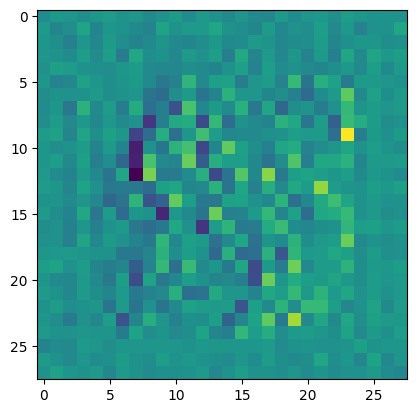

tensor(78847.4688) tensor(-64930.6250)


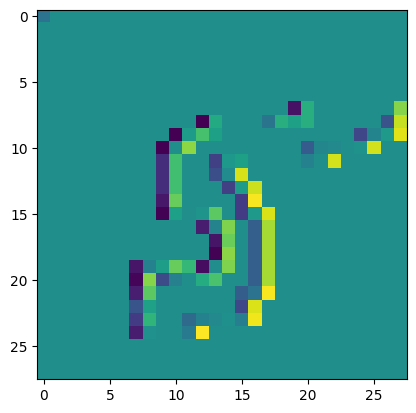

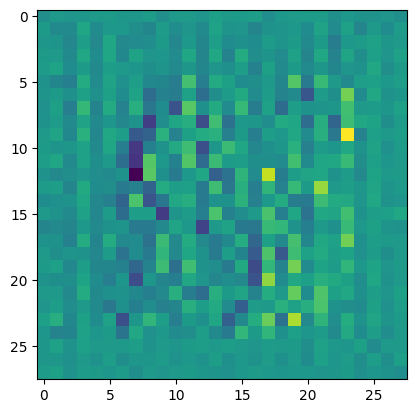

tensor(1846182.8750) tensor(-1549519.)


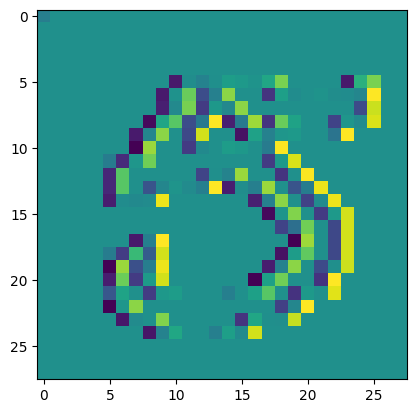

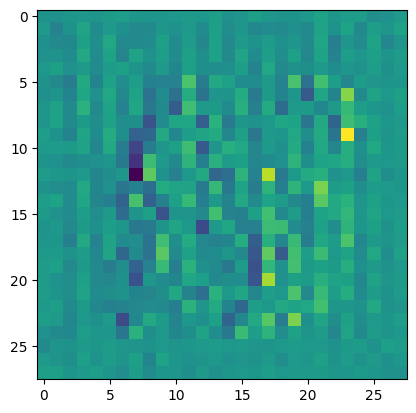

tensor(45737952.) tensor(-46710288.)


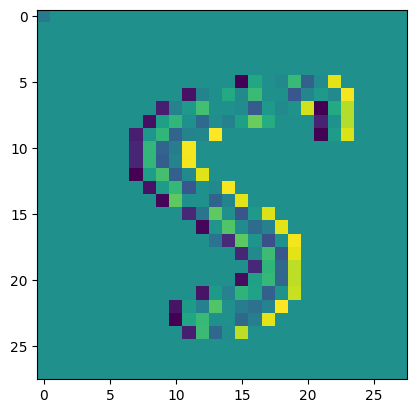

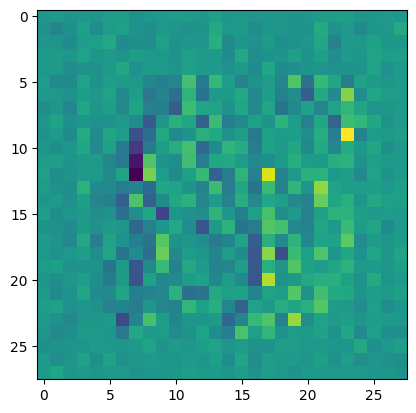

 53%|█████▎    | 16/30 [05:25<04:44, 20.29s/it]

tensor(104.9528) tensor(-97.0305)


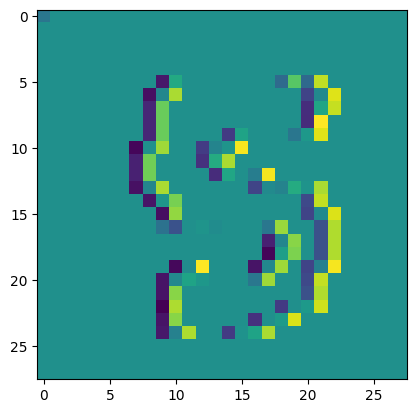

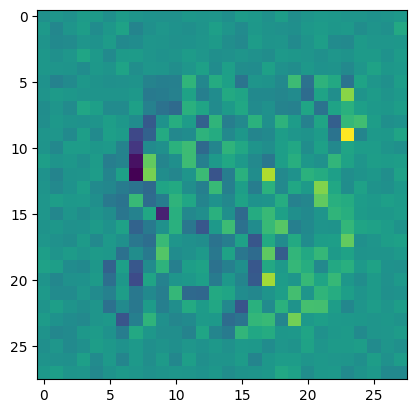

tensor(2420.9202) tensor(-3025.1770)


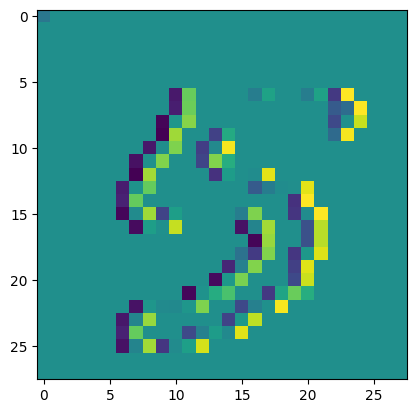

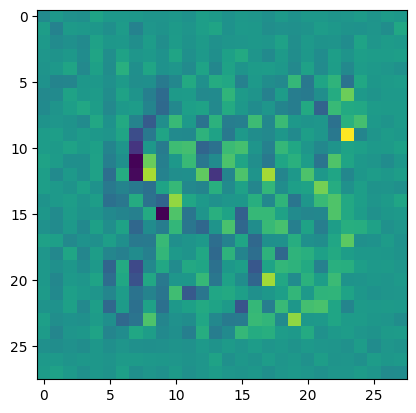

tensor(60270.6211) tensor(-62217.9336)


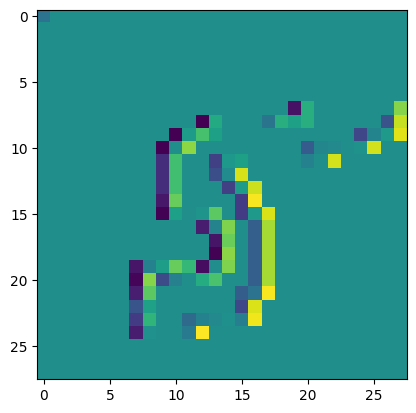

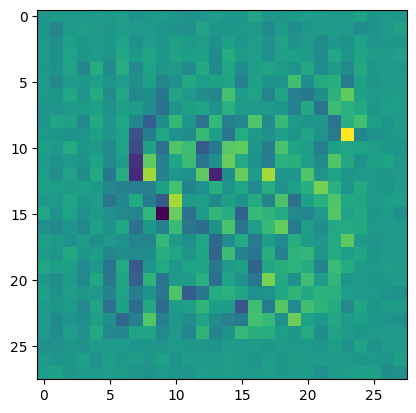

tensor(2176029.2500) tensor(-2354475.)


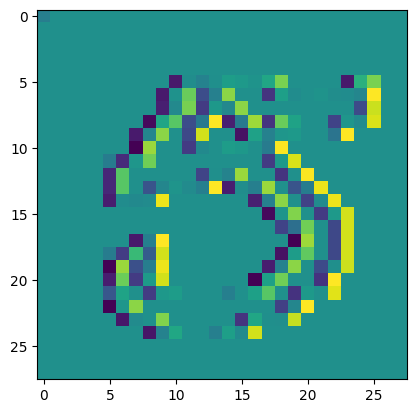

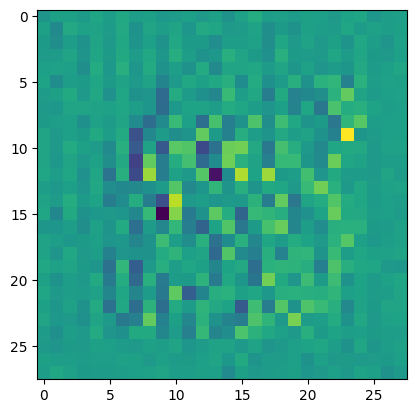

tensor(41135200.) tensor(-37237696.)


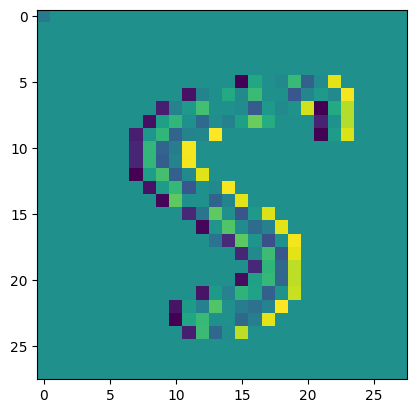

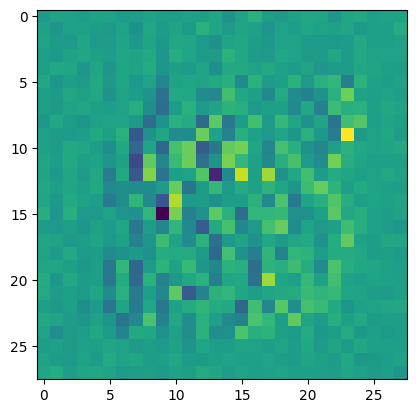

 57%|█████▋    | 17/30 [05:46<04:25, 20.44s/it]

tensor(120.6110) tensor(-102.5819)


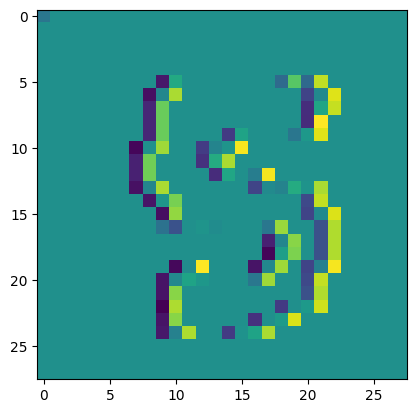

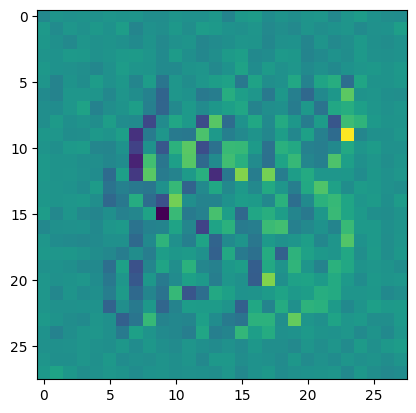

tensor(2956.2078) tensor(-2731.3223)


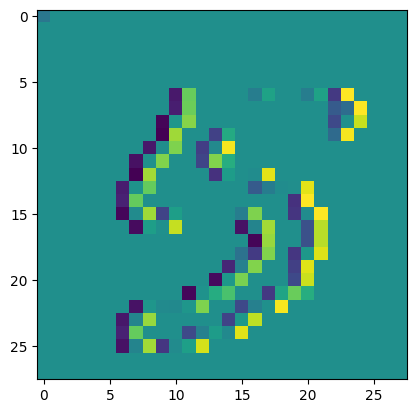

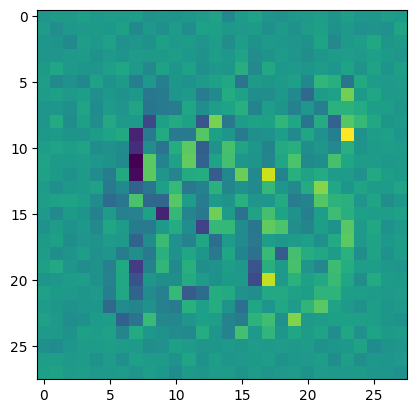

tensor(80891.7969) tensor(-72205.2344)


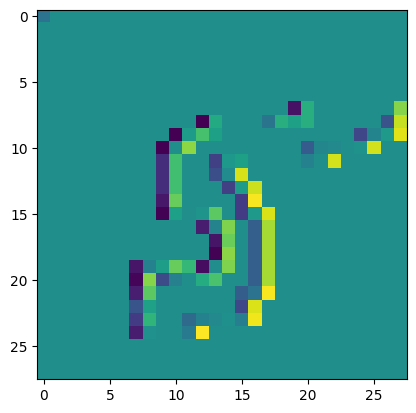

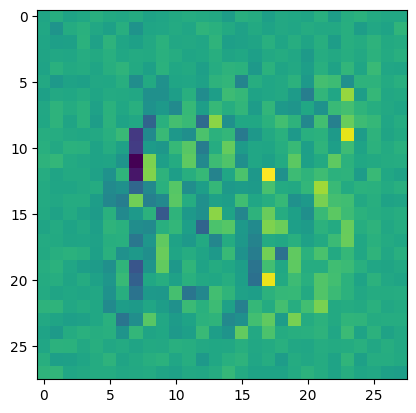

tensor(2027707.8750) tensor(-2048011.1250)


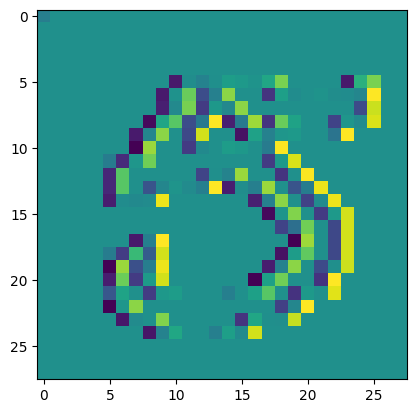

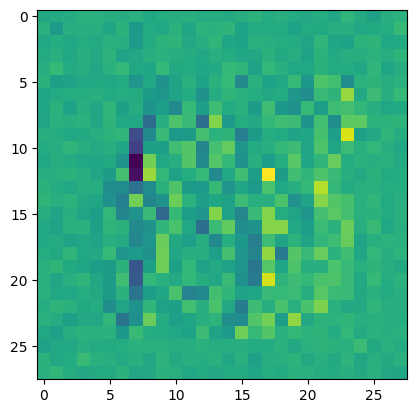

tensor(49867852.) tensor(-47953736.)


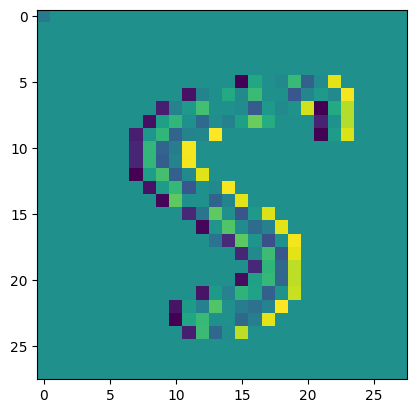

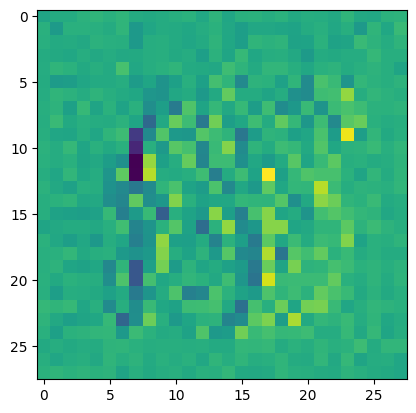

 60%|██████    | 18/30 [06:06<04:03, 20.32s/it]

tensor(93.5718) tensor(-104.3279)


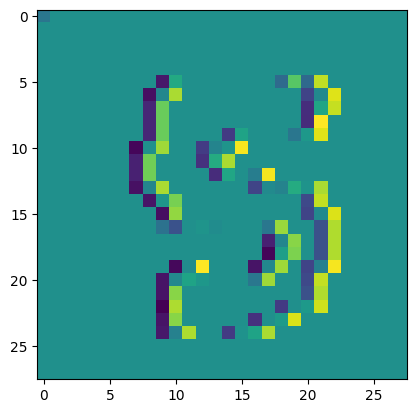

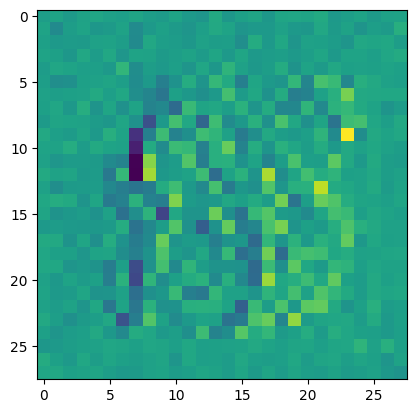

tensor(2782.3079) tensor(-2433.5066)


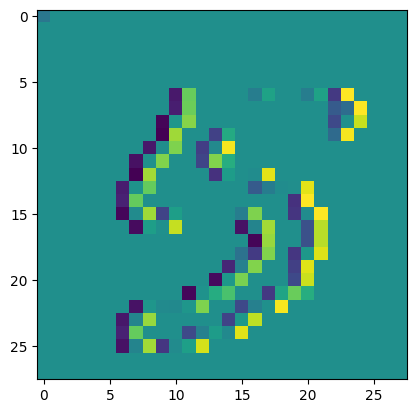

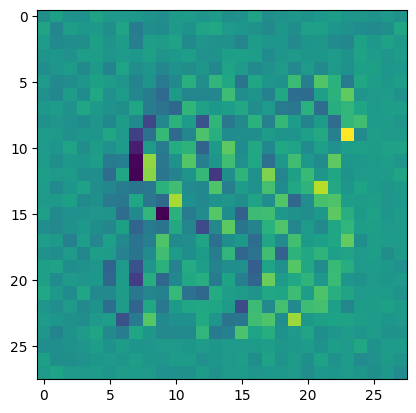

tensor(67982.2656) tensor(-67846.)


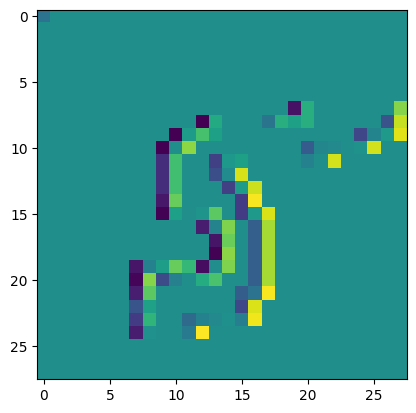

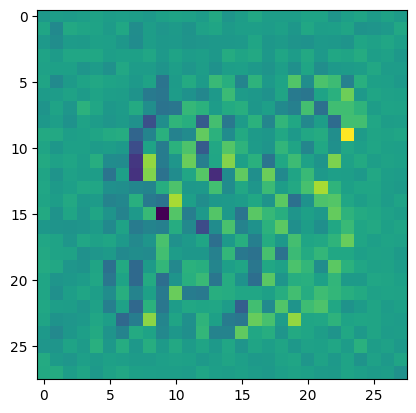

tensor(1865406.3750) tensor(-1970081.5000)


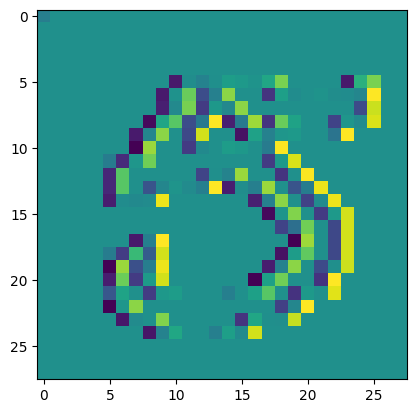

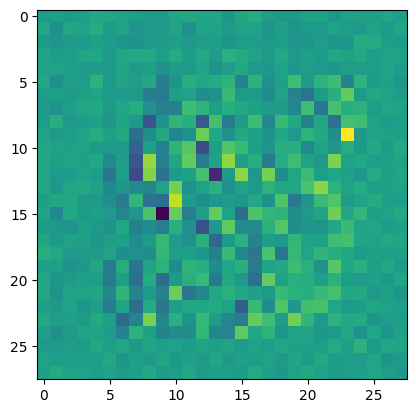

tensor(44526948.) tensor(-47843816.)


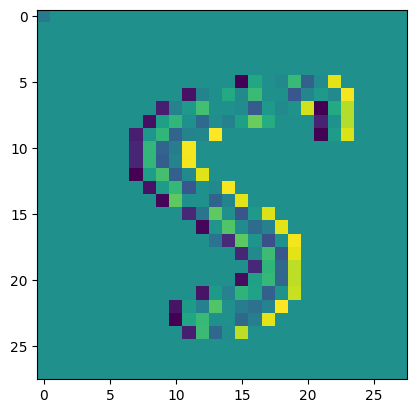

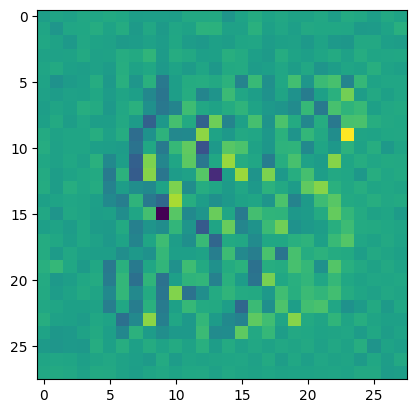

 63%|██████▎   | 19/30 [06:40<04:26, 24.20s/it]

tensor(109.5462) tensor(-132.0238)


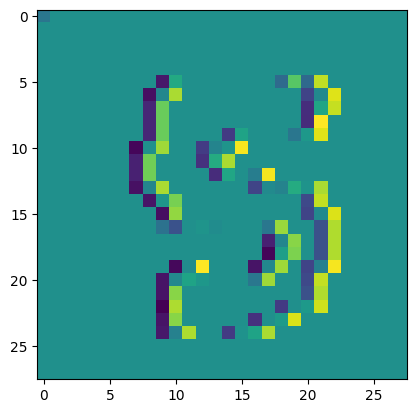

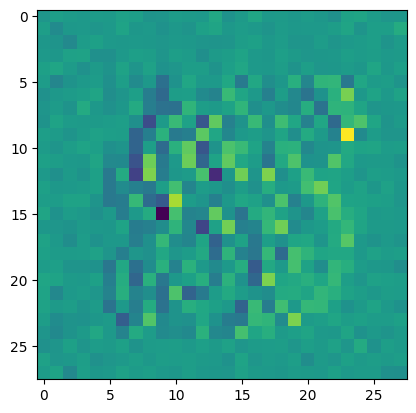

tensor(2328.8416) tensor(-2521.0586)


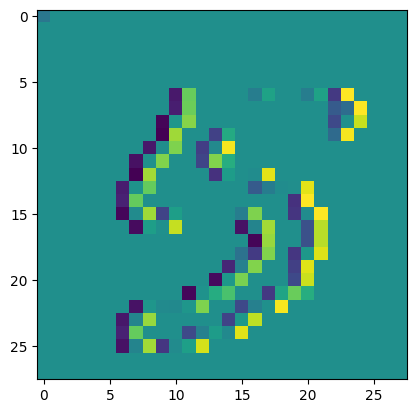

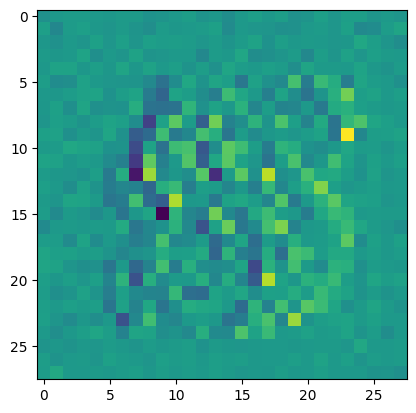

tensor(64989.4375) tensor(-86416.5859)


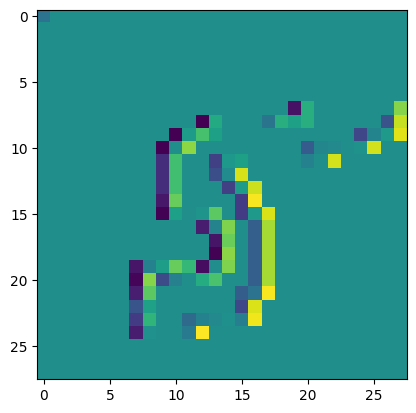

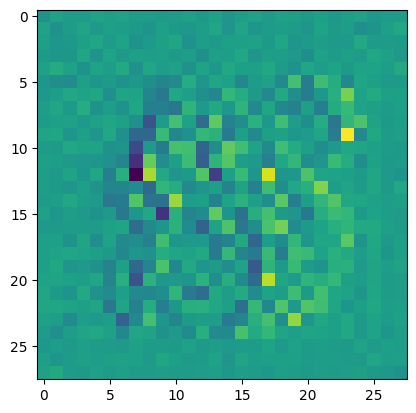

tensor(1585818.1250) tensor(-1787479.6250)


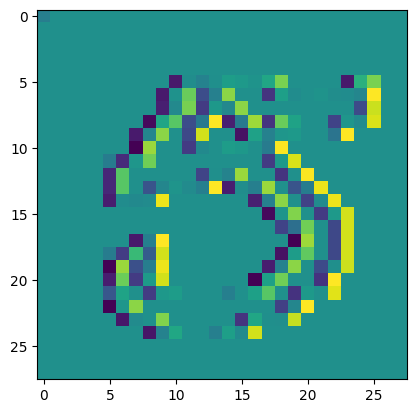

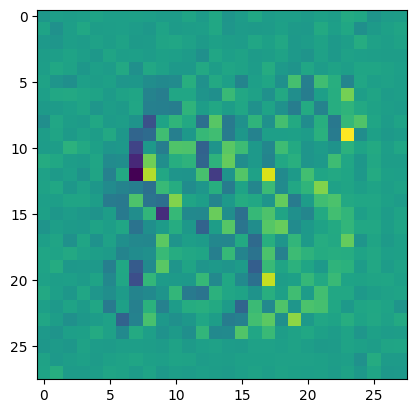

tensor(48041484.) tensor(-38159208.)


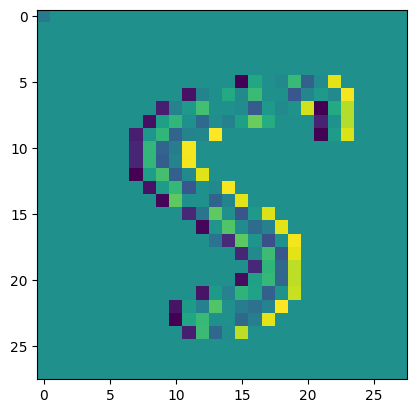

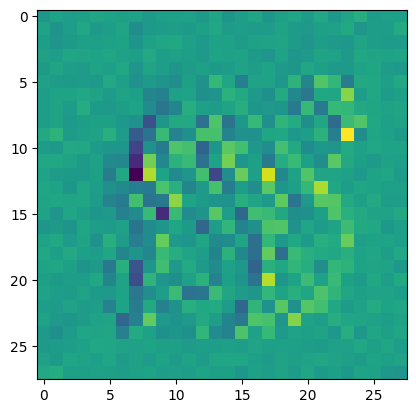

 67%|██████▋   | 20/30 [07:00<03:50, 23.04s/it]

tensor(114.4945) tensor(-106.5372)


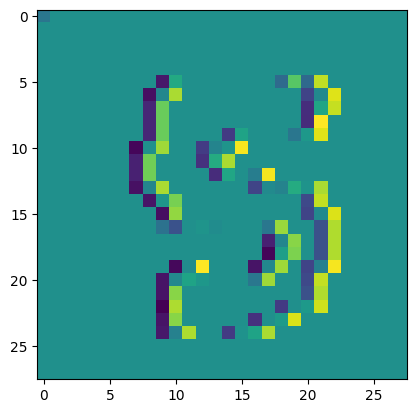

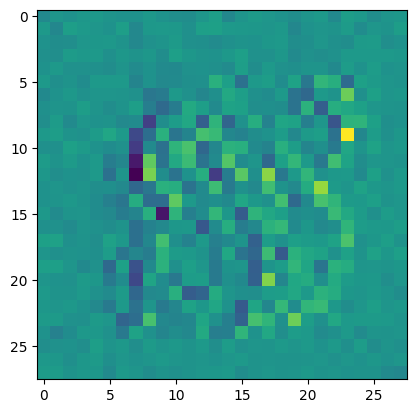

tensor(3002.1804) tensor(-2967.0752)


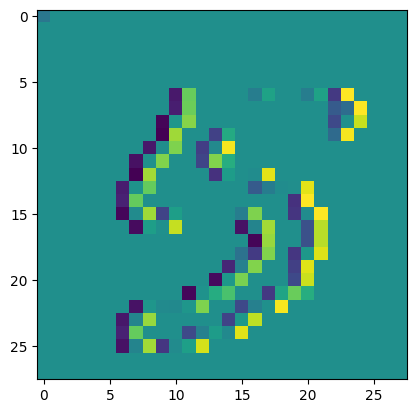

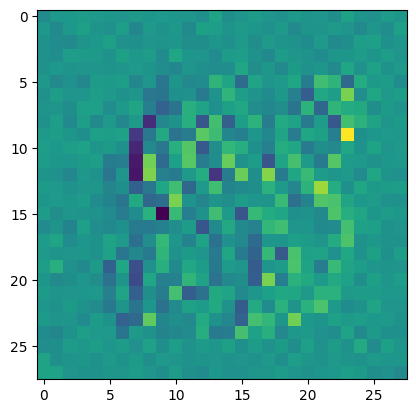

tensor(61329.9570) tensor(-64473.2734)


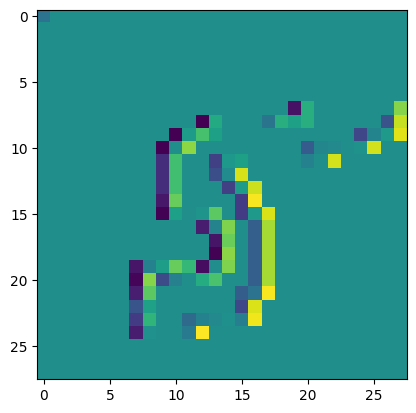

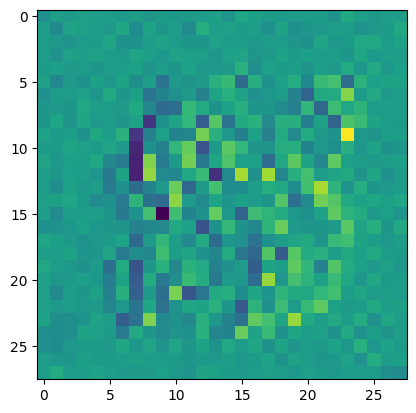

tensor(1750627.3750) tensor(-1860785.8750)


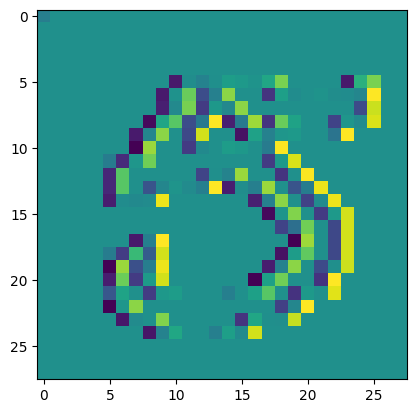

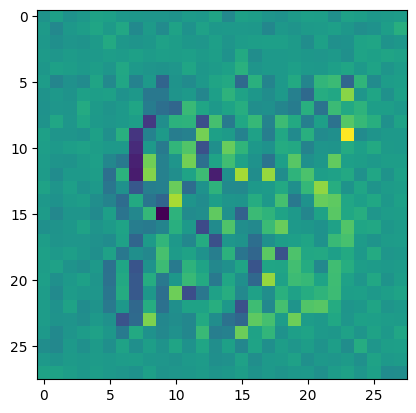

tensor(41768208.) tensor(-44295132.)


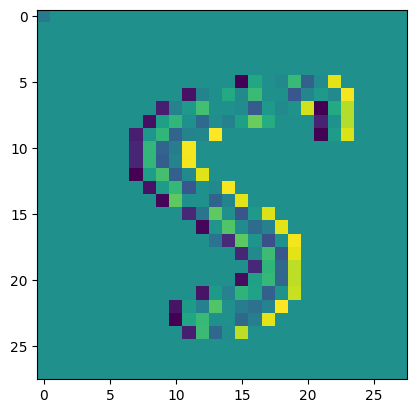

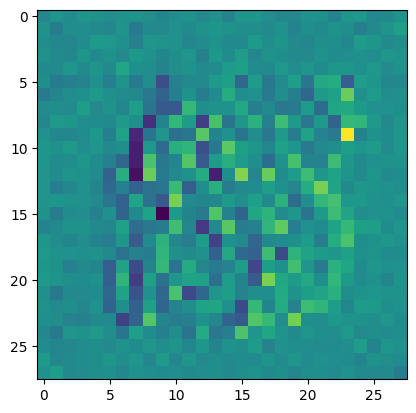

 70%|███████   | 21/30 [07:20<03:20, 22.23s/it]

tensor(104.8208) tensor(-132.3027)


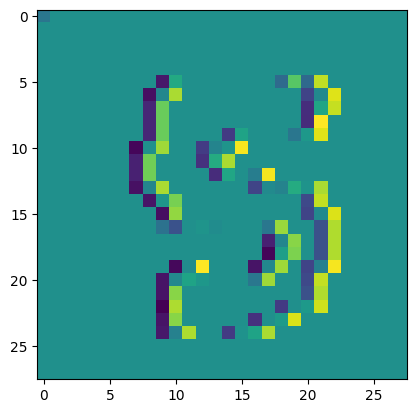

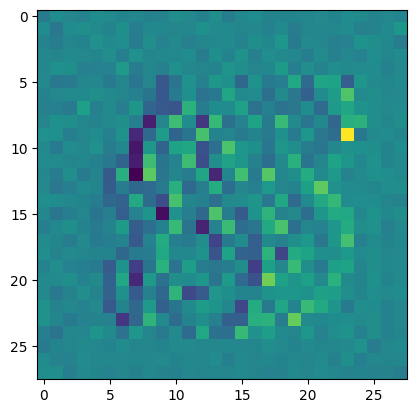

tensor(2462.9844) tensor(-3304.4500)


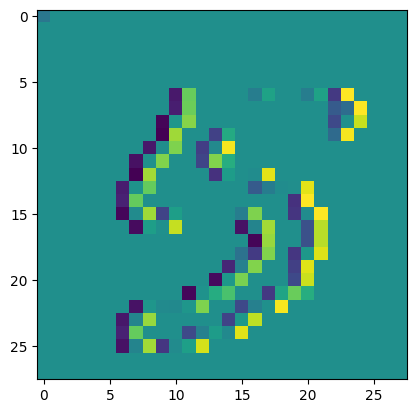

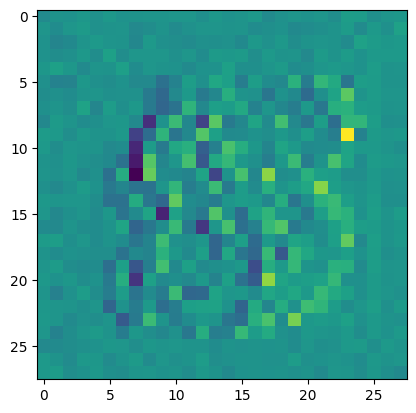

tensor(70792.5234) tensor(-63128.7305)


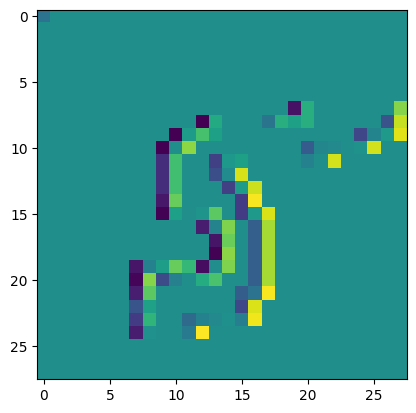

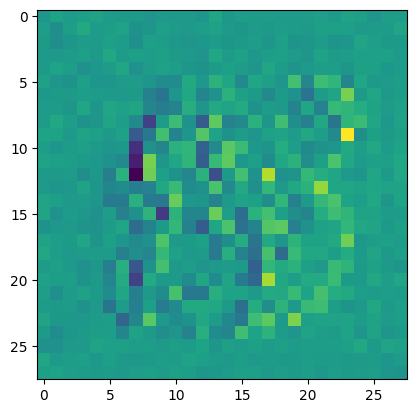

tensor(1450490.3750) tensor(-2058734.8750)


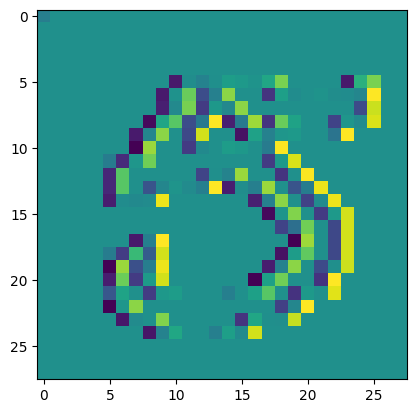

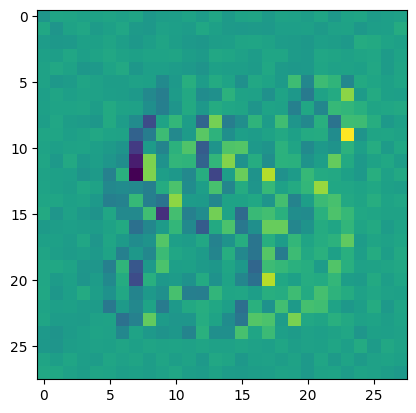

tensor(52948076.) tensor(-38029840.)


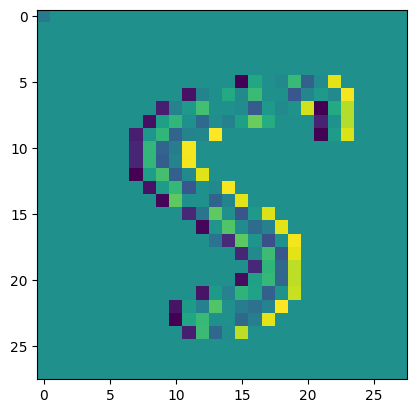

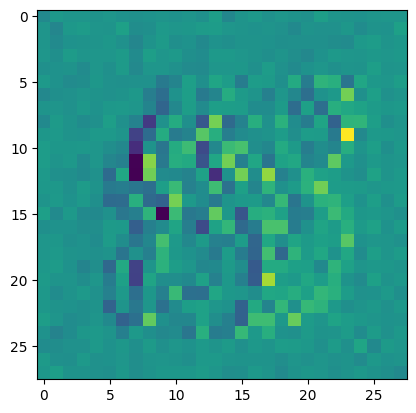

 73%|███████▎  | 22/30 [07:40<02:52, 21.58s/it]

tensor(115.2361) tensor(-126.2535)


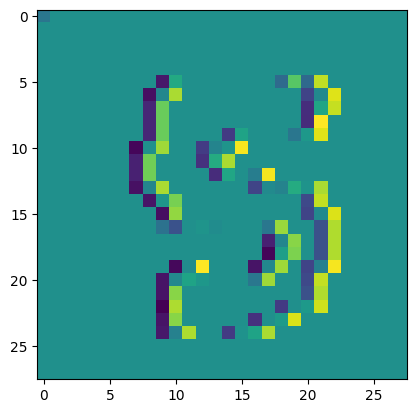

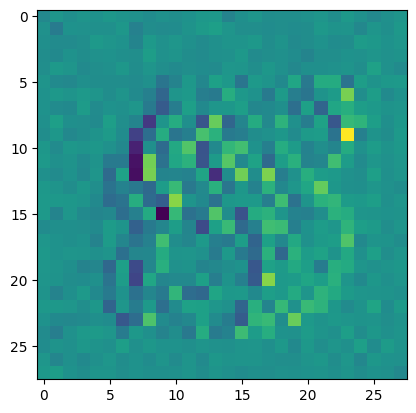

tensor(2977.3171) tensor(-2794.3027)


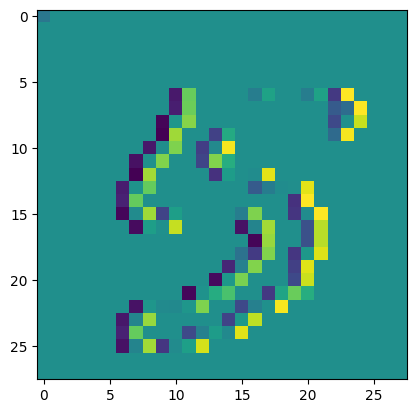

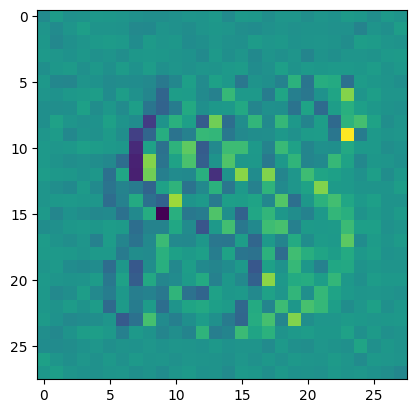

tensor(56406.2031) tensor(-63638.3945)


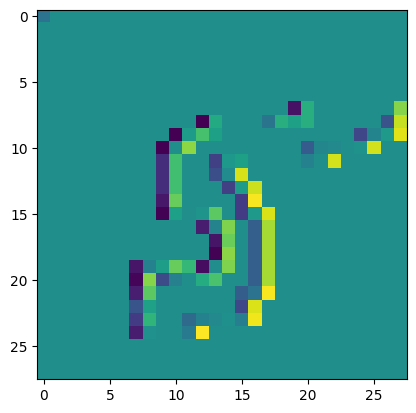

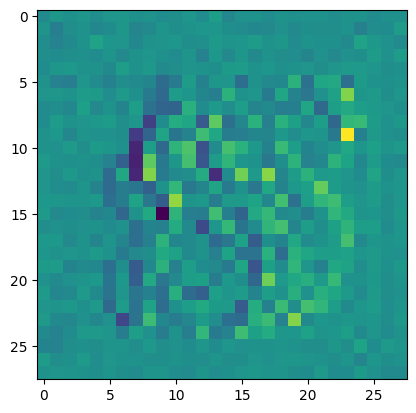

tensor(1631322.6250) tensor(-1616543.1250)


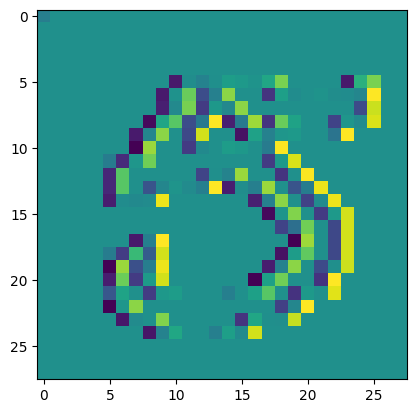

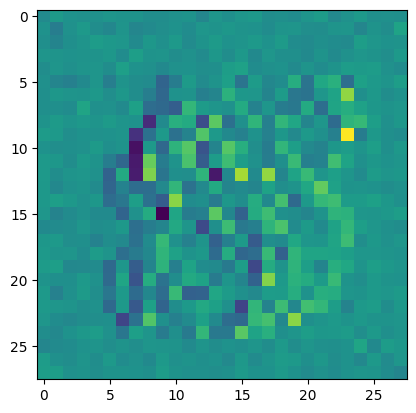

tensor(36807728.) tensor(-43961376.)


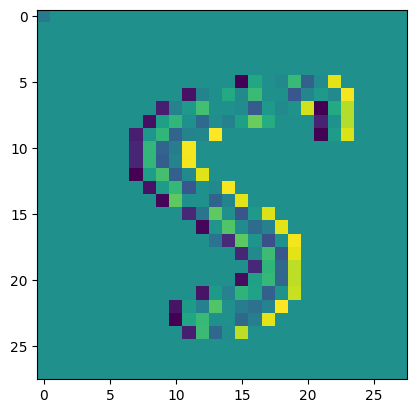

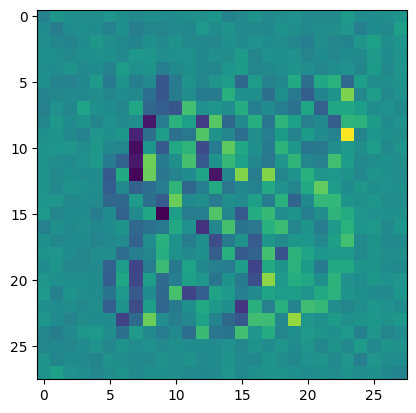

 77%|███████▋  | 23/30 [08:01<02:28, 21.28s/it]

tensor(106.4216) tensor(-101.9037)


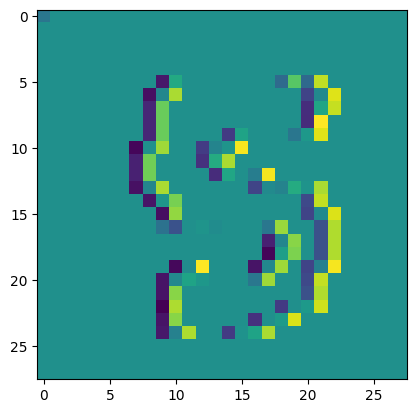

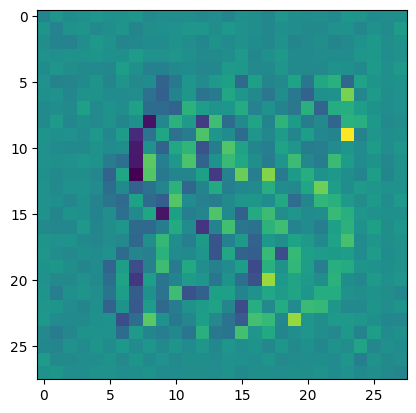

tensor(2297.0864) tensor(-2545.6602)


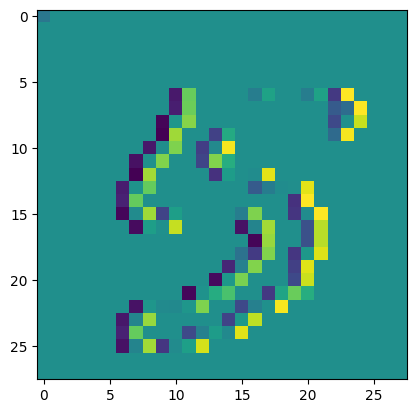

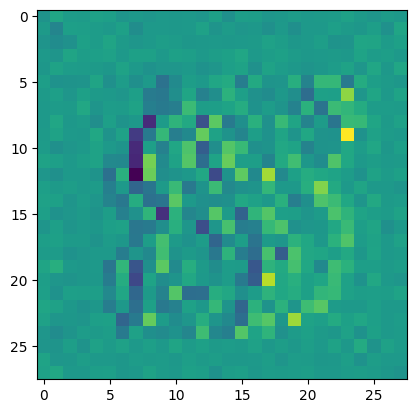

tensor(64879.6797) tensor(-79305.1016)


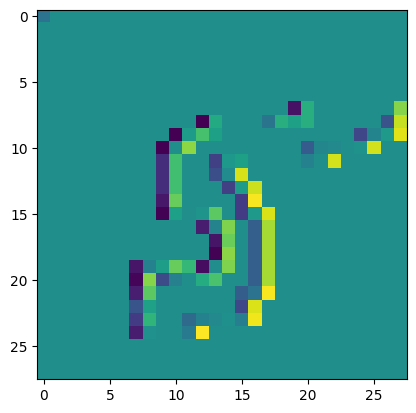

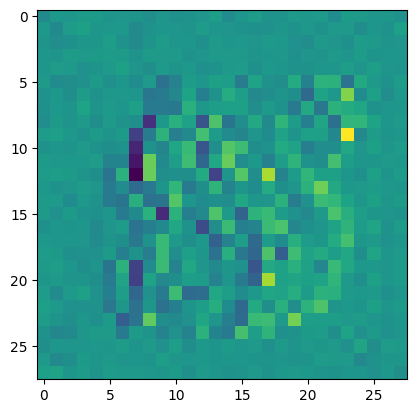

tensor(1455721.8750) tensor(-1952302.8750)


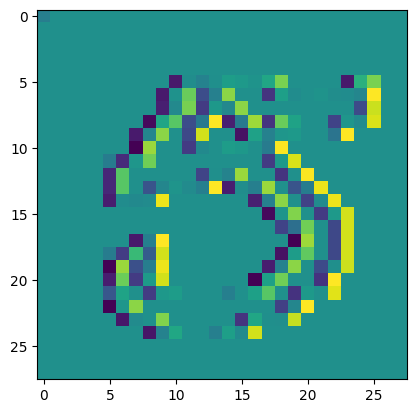

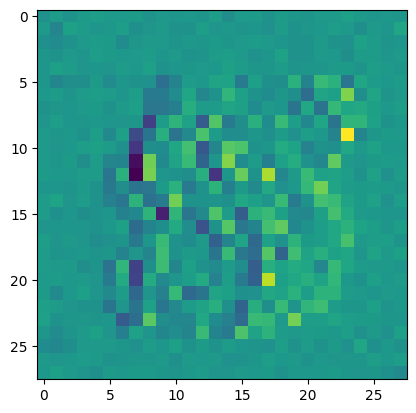

tensor(44413320.) tensor(-45939744.)


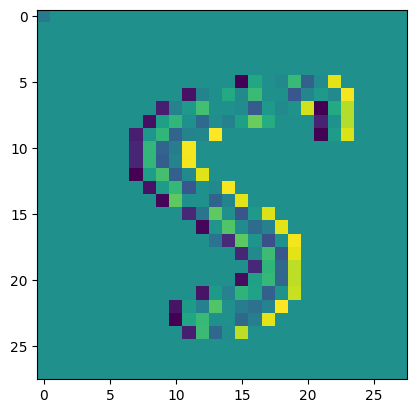

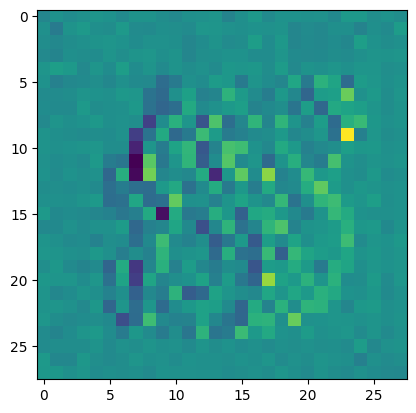

 80%|████████  | 24/30 [08:22<02:06, 21.14s/it]

tensor(99.3445) tensor(-120.6273)


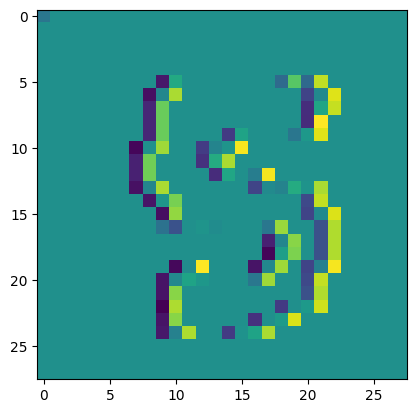

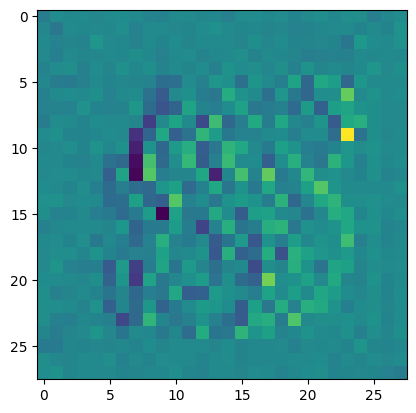

tensor(2756.9150) tensor(-2752.6382)


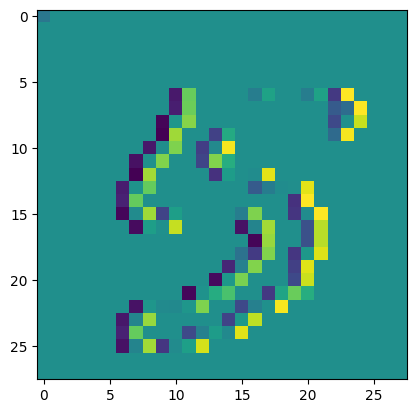

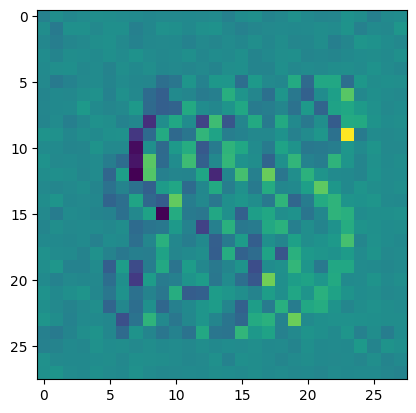

tensor(69737.8828) tensor(-76706.5469)


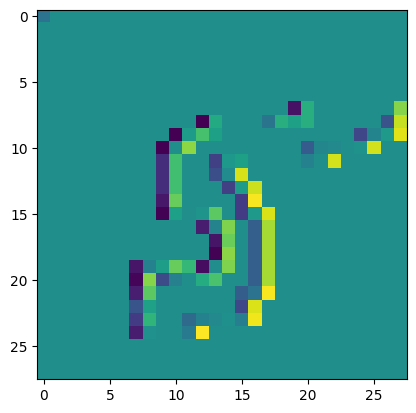

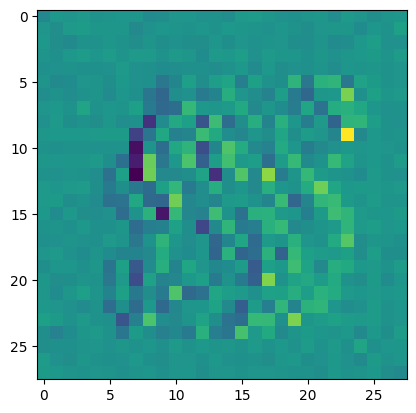

tensor(1600707.6250) tensor(-1643787.7500)


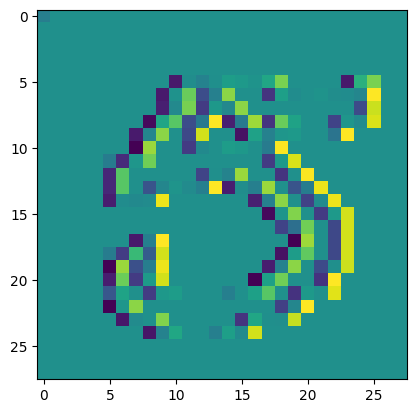

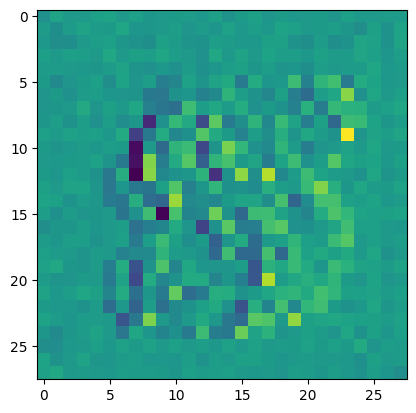

tensor(45035748.) tensor(-38813552.)


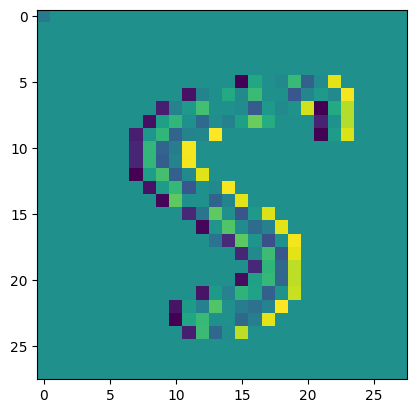

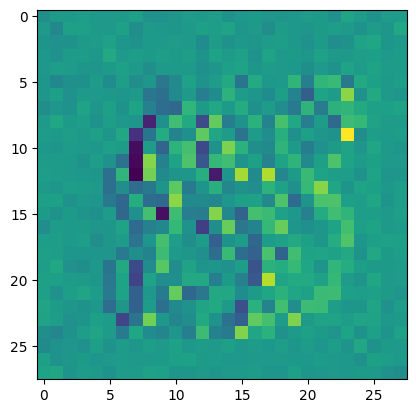

 83%|████████▎ | 25/30 [08:42<01:44, 20.80s/it]

tensor(125.0555) tensor(-104.7767)


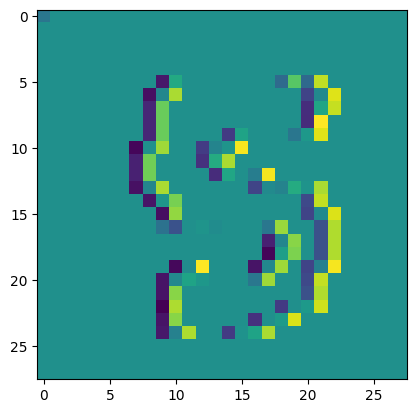

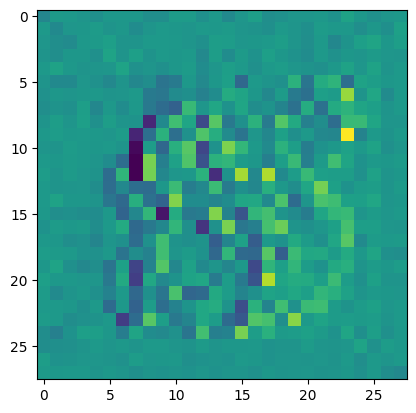

tensor(3234.1113) tensor(-2966.6965)


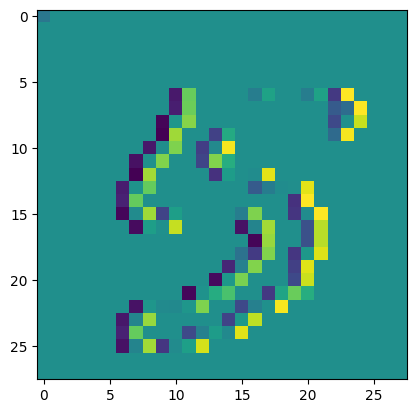

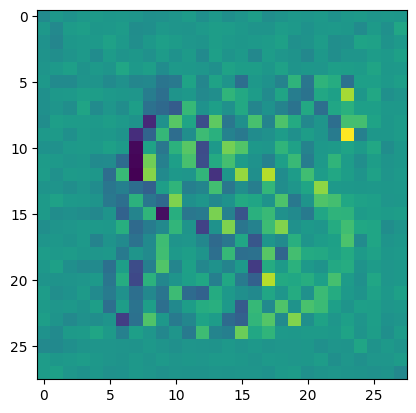

tensor(68882.6797) tensor(-69490.8438)


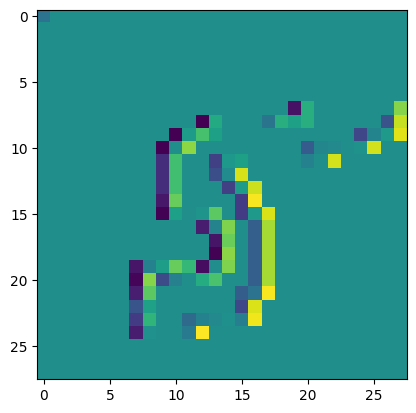

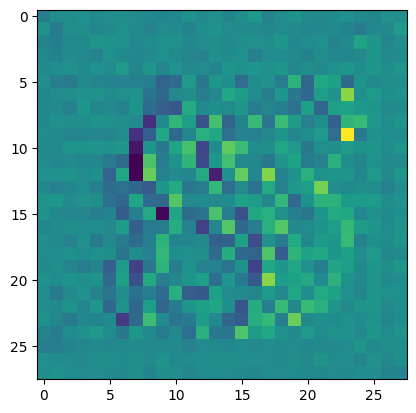

tensor(2104574.) tensor(-1655672.7500)


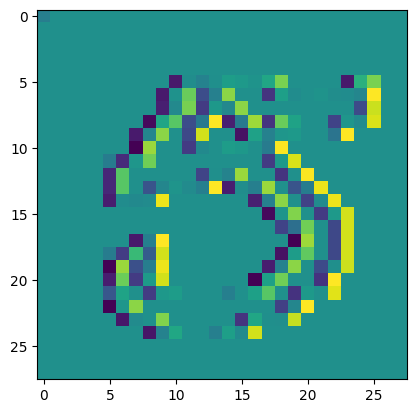

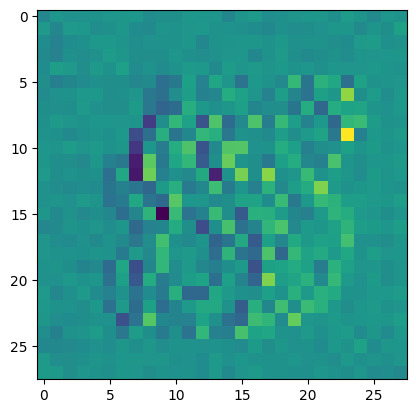

tensor(38257928.) tensor(-49423832.)


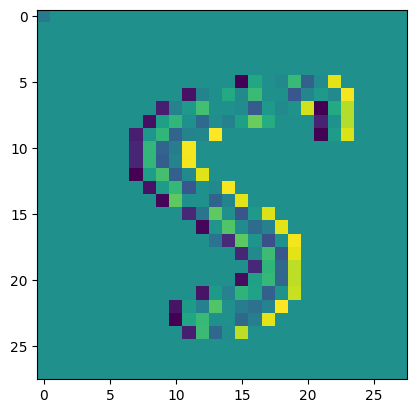

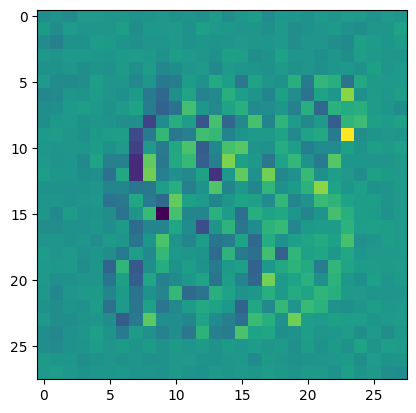

 87%|████████▋ | 26/30 [09:02<01:22, 20.74s/it]

tensor(110.0467) tensor(-97.9039)


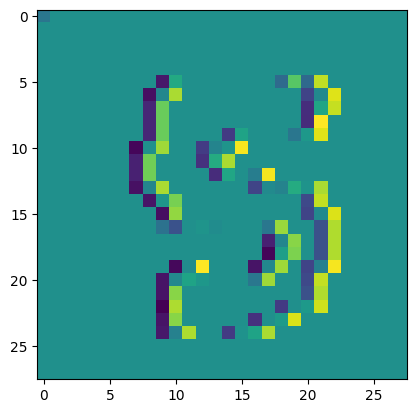

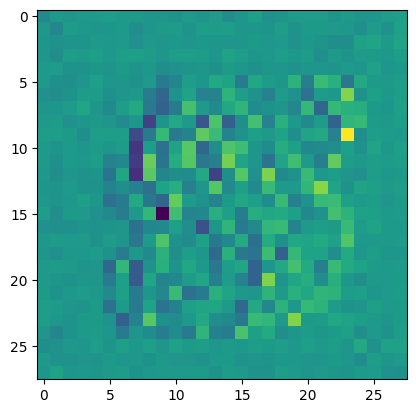

tensor(2648.1350) tensor(-2920.6328)


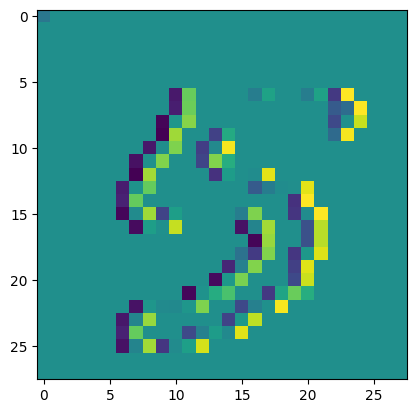

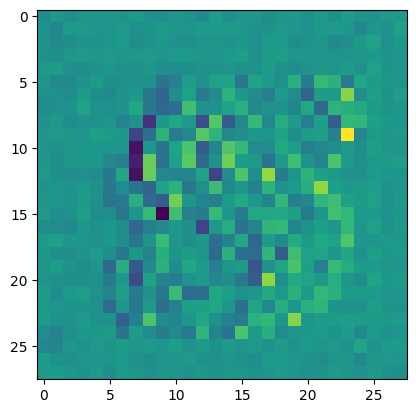

tensor(76603.7188) tensor(-63486.2891)


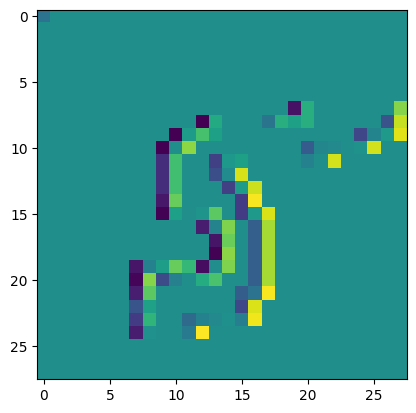

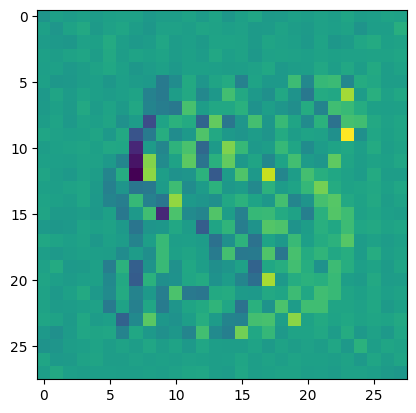

tensor(1868573.7500) tensor(-1474133.1250)


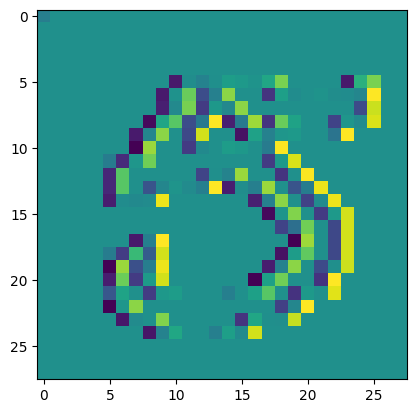

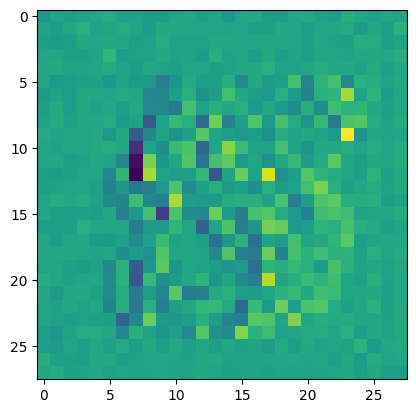

tensor(42954072.) tensor(-54702616.)


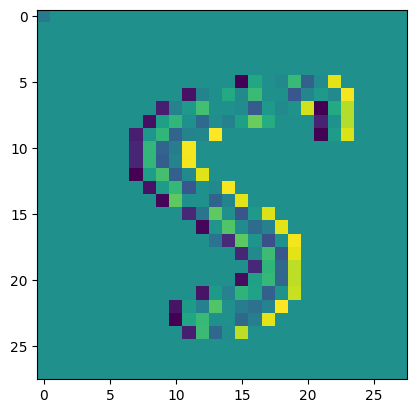

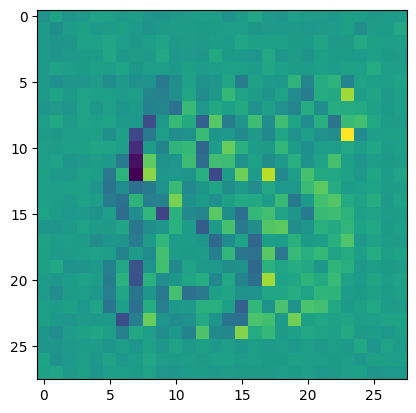

 90%|█████████ | 27/30 [09:22<01:01, 20.41s/it]

tensor(98.4531) tensor(-103.2557)


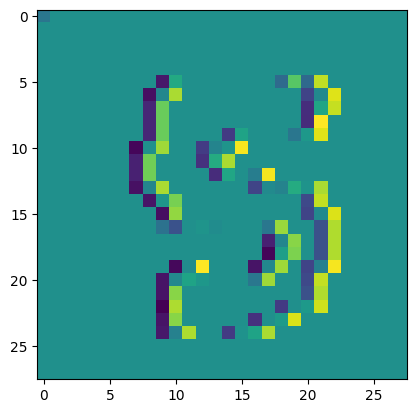

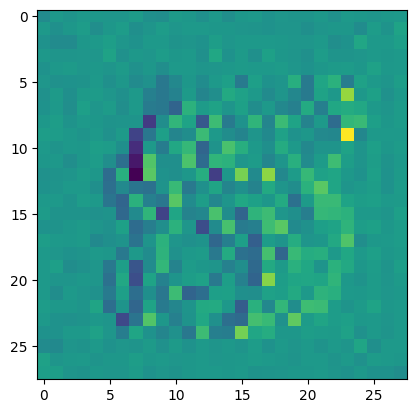

tensor(2777.3867) tensor(-3082.1433)


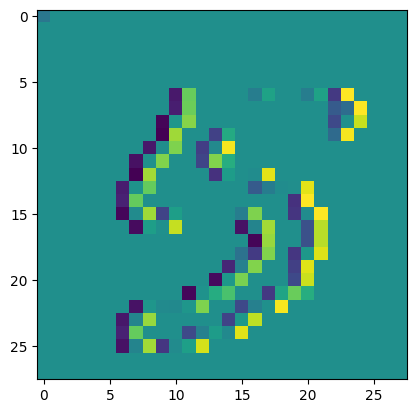

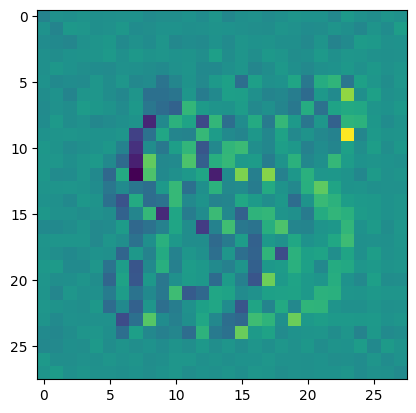

tensor(60571.7578) tensor(-76429.9375)


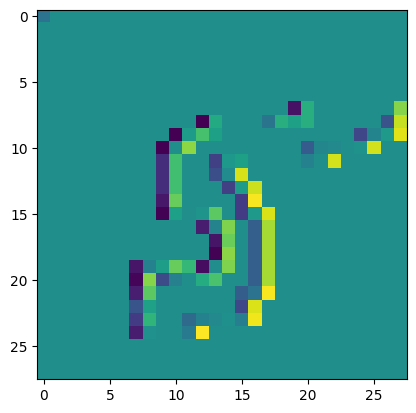

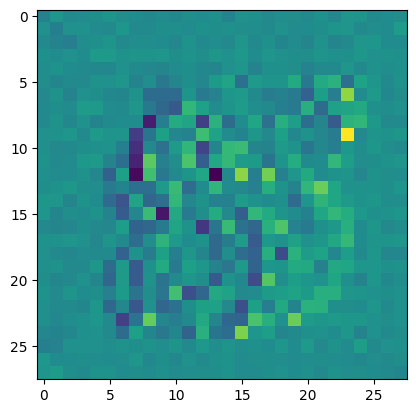

tensor(1627094.) tensor(-1465207.3750)


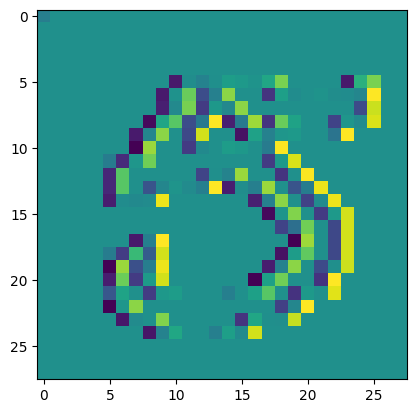

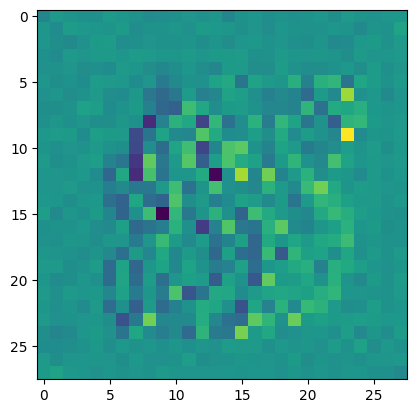

tensor(36178576.) tensor(-36001772.)


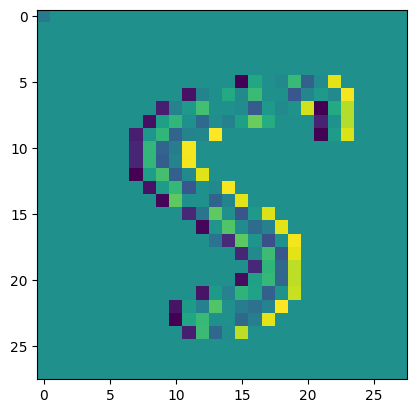

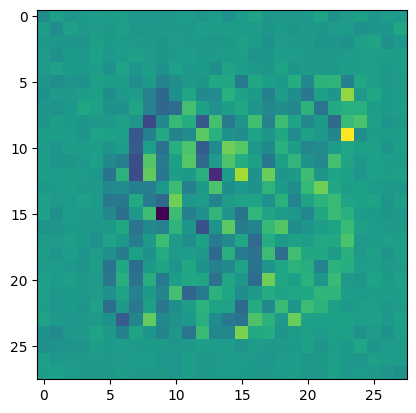

 93%|█████████▎| 28/30 [09:42<00:40, 20.46s/it]

tensor(109.9485) tensor(-99.6328)


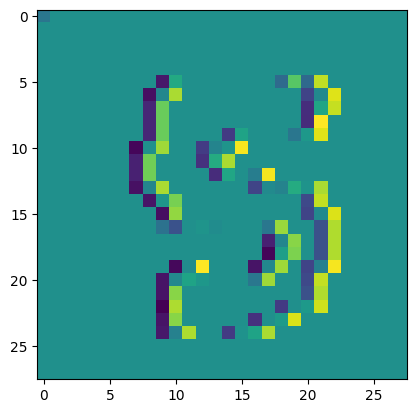

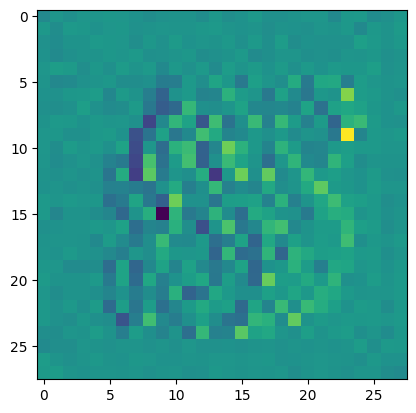

tensor(2620.6426) tensor(-2902.9346)


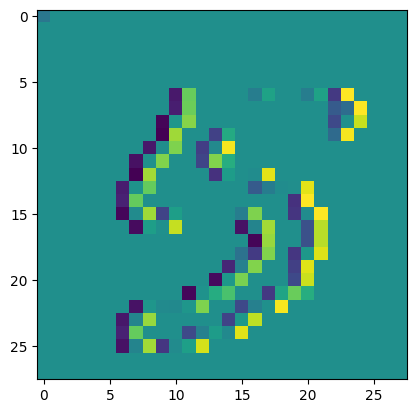

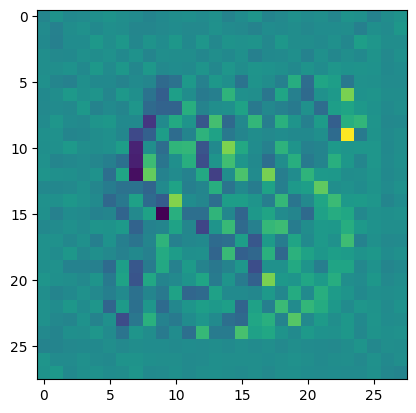

tensor(71284.2031) tensor(-61291.6875)


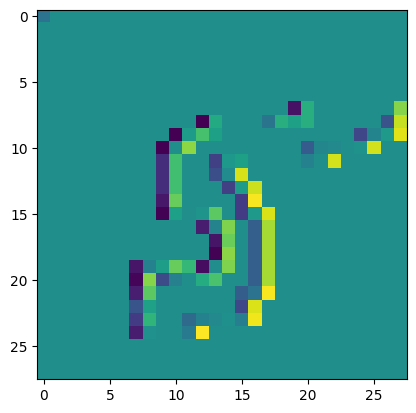

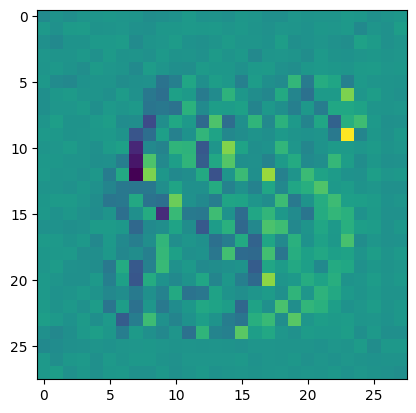

tensor(1722206.) tensor(-1917699.8750)


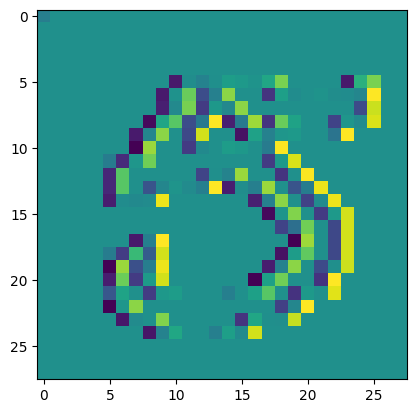

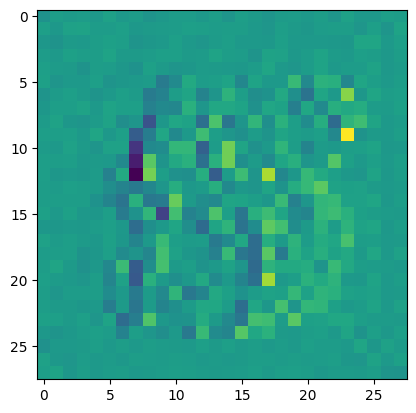

tensor(49670024.) tensor(-47198824.)


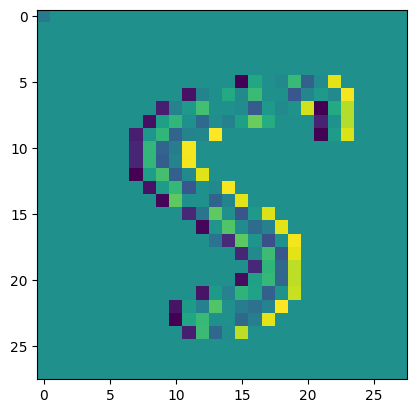

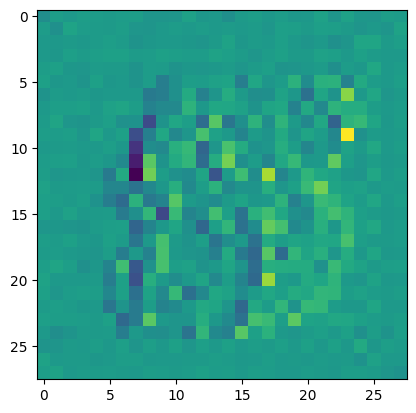

 97%|█████████▋| 29/30 [10:03<00:20, 20.44s/it]

tensor(114.0843) tensor(-117.7603)


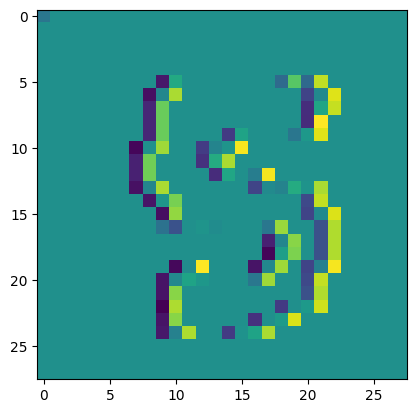

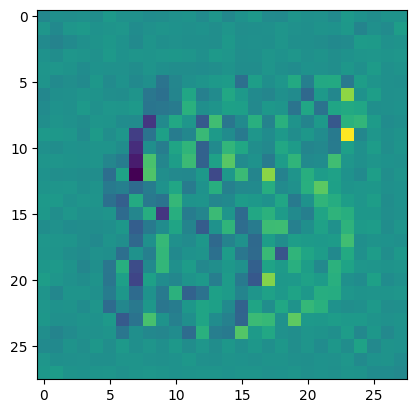

tensor(2700.8452) tensor(-2663.8406)


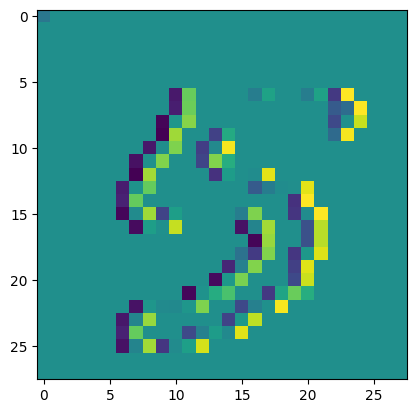

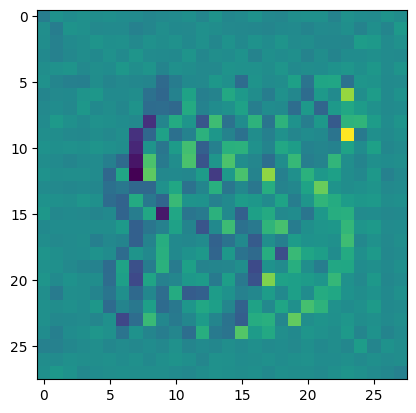

tensor(66347.9141) tensor(-74302.1328)


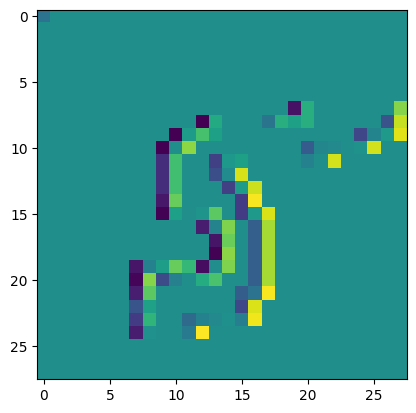

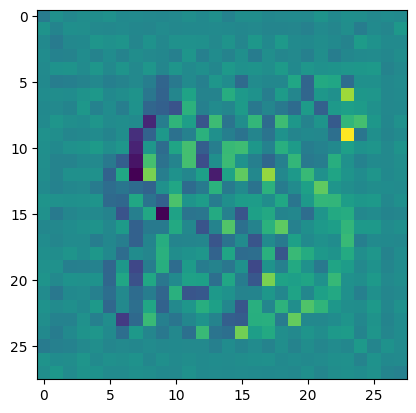

tensor(1775719.1250) tensor(-1926538.2500)


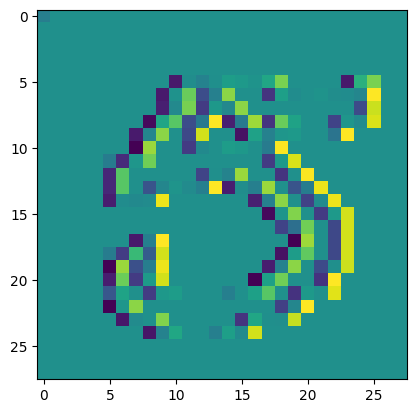

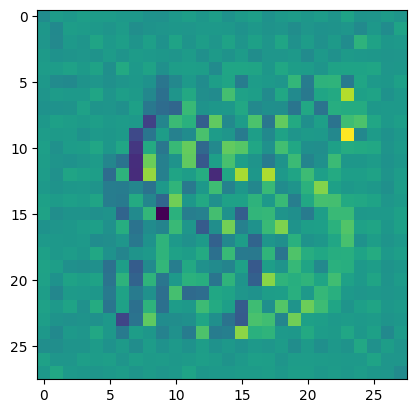

tensor(40573012.) tensor(-47931608.)


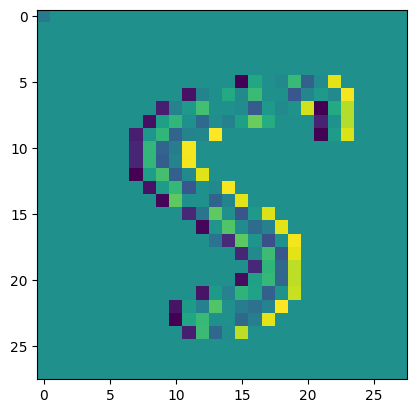

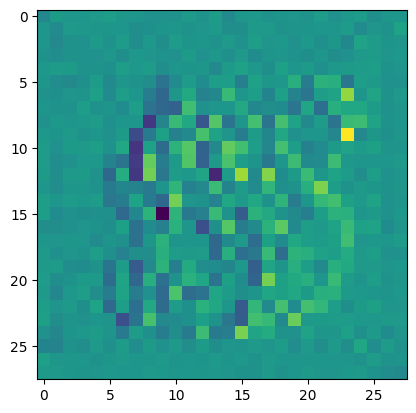

100%|██████████| 30/30 [10:23<00:00, 20.78s/it]


model has been saved


In [5]:
# we want to sample from random time steps to construct training samples
random_t = np.zeros((len(mnist_data), N-1))
for idx in range(len(mnist_data)):
  dt = (idx + 1)/N
  random_t[idx, 1:-1] = np.random.rand(N-3)
  random_t[idx, 0] = dt # first step we want something small
  random_t[idx, -1] = idx + 1
  random_t[idx] = np.sort(random_t[idx]) # we sort the time in increasing order for denoising

for e in tqdm(range(epoch)):
  perturbed_x = torch.zeros((len(mnist_data), N, 1, H, W))
  m = np.zeros((len(mnist_data), N, H*W), dtype=np.float32)
  del_m = np.zeros_like(m, dtype=np.float32)
  m_c = np.zeros((len(mnist_data), N, int((H*W/4))), dtype=np.float32)
  scores = np.zeros((len(mnist_data), N, H, W), dtype=np.float32)

  for idx, x_ in enumerate(mnist_data):
    time_ = np.insert(random_t[idx], 0, eps).astype(np.float32) # for denoising we want time 0 to always be in sample to train
    sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()

    data = x_
    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    params = {"bandwidth": np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params)
    kde = grid.fit(data.ravel()[:, None])
    m[idx, 0] = kde.score_samples(data.ravel()[:, None])
    del_m[idx, 0] = np.diff(m[idx, 0].ravel(), axis=0, prepend=0)

    # we normalize for sigma to ensure the dynamics doesn't blow up
    A_block = []
    for i, t_ in enumerate(random_t[idx], 1):
      A = construct_A(dx, dy, t_ - time_[i-1], np.zeros((H, W)), sigma_[i], scores[idx, i], H, W)
      if i == 1:
        A_block = sp.linalg.block_diag(A)
      else:
        A_block = sp.linalg.block_diag(A_block, A)
        A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])

    B = construct_B(dx, dy, time_[1] - time_[0], m[idx, 0], np.zeros((H, W)), sigma_[1], scores[idx, 1])
    B_block = np.zeros(A_block.shape[0])
    B_block[:H*W] = B

    # update m (pre-smoothing)
    m[idx, 1:] = gauss_seidel(A_block, B_block, scores[idx, 1:].flatten()).reshape(((N-1), H*W))
    R = construct_R(int(H/2), int(H))
    P = construct_P(R)
    R_block = []
    P_block = []
    for i, t_ in enumerate(random_t[idx], 1):
      ####### kernal preserving restriction ####
      R_block = construct_R_block(R, R_block, i)
      ####### bilinear interpolation ###########
      P_block = construct_P_block(P, P_block, i)

    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@m[idx, 1:].flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)
    A_c = (sparse.csr_matrix(R_block)@sparse.csr_matrix(A_block)@sparse.csr_matrix(P_block)).toarray()
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sparse')
    # interpolate to fine grid: err = P_c@err_c
    err = P_block@err_c
    # we apply fine grid-correction
    m[idx, 1:] = (m[idx, 1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[idx, 1:] = gauss_seidel(A_block, B_block, m[idx, 1:].flatten()).reshape(((N-1), H*W))
    # we want to coarsen the score function to train on coarse data
    m_c[idx, 1:] = (R_block@m[idx, 1:].flatten()).reshape((-1, int(H*W/4)))

    # constructing the training data and labels
    for i, t_ in enumerate(random_t[idx], 1):
      del_m[idx, i] = np.diff(m[idx, i].ravel(), axis=0, prepend=0)

    lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]

    x = torch.tensor(np.exp(((-m[idx].ravel() - logsumexp(-m[idx].ravel()))))[:, None]).reshape((N, 1, H, W)) #
    perturbed_x[idx] = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    print(perturbed_x[idx].max(), perturbed_x[idx].min())

    train_x_data = perturbed_x[idx]
    train_y_data = torch.tensor(del_m[idx].astype(np.float32)).reshape((N, 1, H, W))
    plt.imshow(train_y_data[-1].reshape((H, W)))
    plt.show()

    # generate coarse dataset
    x_c = torch.tensor(np.exp(((-m_c[idx].ravel() - logsumexp(-m_c[idx].ravel()))))[:, None]).reshape((N, 1, int(H/2), int(W/2)))
    perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    train_xc_data = perturbed_xc

    yc_pred = model_score(train_xc_data, torch.tensor(time_), coarse=True)
    loss = loss_fn(yc_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()

    y_pred = model_score(train_x_data, torch.tensor(time_))
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()

    scores[idx] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W)) # we normalize before fedding back into PDE
    plt.imshow(scores[idx, 0].reshape((H, W))) # so we can see that the score should look something like this after training
    plt.show()

torch.save(model_score.state_dict(), 'model.pth')
print(f"\nmodel has been saved")

In [18]:
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from network import ScoreNet
from kfp import diffusion_coeff

idx = 4
sigma = 25 #(25 * np.linspace(1, (len(mnist_data) + 1), len(mnist_data)))[idx]
eps = 1e-6

model_score = ScoreNet()
ckpt = torch.load('model.pth', map_location=torch.device('cpu'))
model_score.load_state_dict(ckpt)
model_score.eval();

H = 28
W = 28
N = 10

In [19]:
## The error tolerance for the black-box ODE solver
def ode_sampler(score_model,
                diffusion_coeff,
                batch_size=64,
                z=None,
                eps=eps):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, H, W) * torch.sqrt(2 * diffusion_coeff(torch.ones(batch_size, 1, H, W) + idx/(len(mnist_data) - 1), sigma)**2)
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample_ = torch.tensor(sample, dtype=torch.float32).reshape(shape)
    t_ = torch.tensor(time_steps, dtype=torch.float32).reshape((sample_.shape[0],))
    with torch.no_grad():
      score_ = score_model(sample_, t_)
    return score_.cpu().numpy().reshape((-1))

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    # time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t), sigma)
    return  -0.5 * (g**2) * score_eval_wrapper(x, t)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (idx + 1, eps), init_x.reshape(-1))
  print(f"Number of function evaluations: {res.nfev}")
  sol = res.y #[:, -1].reshape(shape)
  return sol

Number of function evaluations: 800


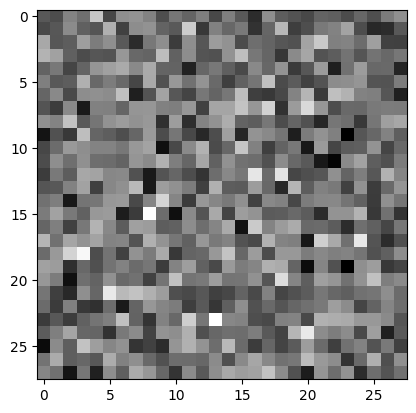

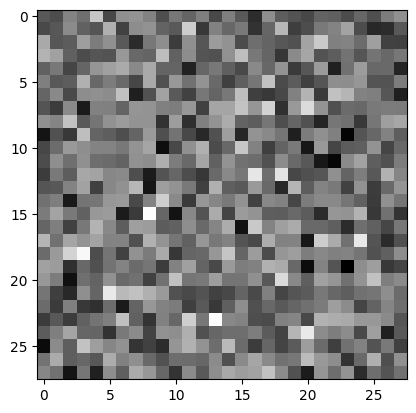

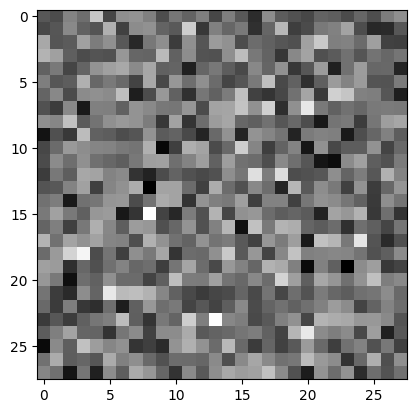

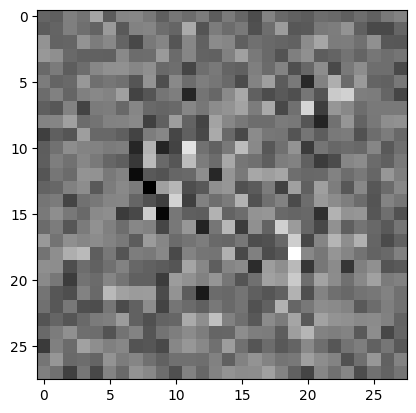

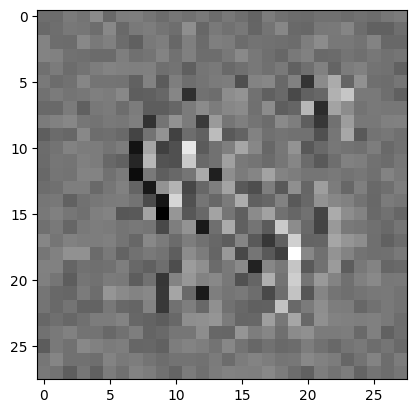

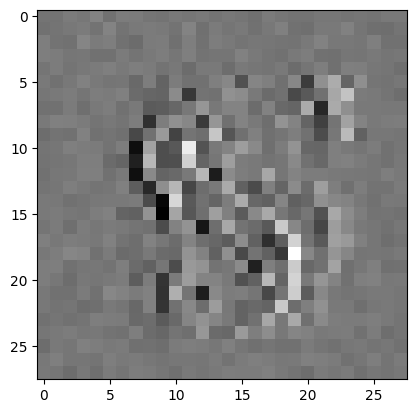

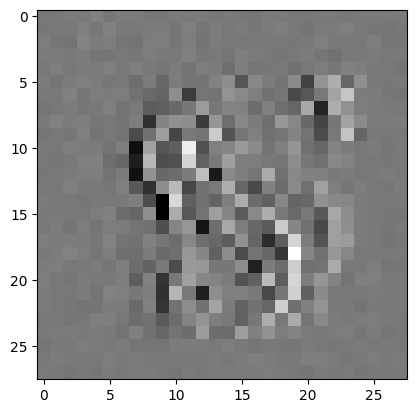

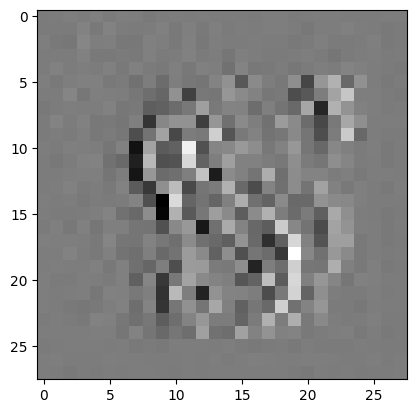

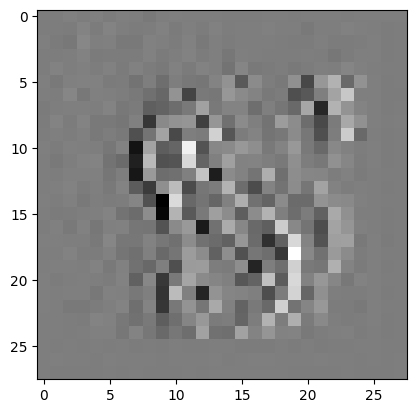

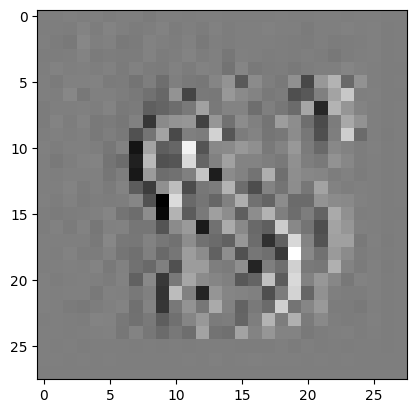

In [20]:
sample_batch_size = 1
sampler = ode_sampler

# init_x = np.load("../init.npy")[-1].reshape((sample_batch_size, 1, H, W))
init_x = perturbed_x[idx, -1].unsqueeze(0)

## Generate samples using the specified sampler.
samples = sampler(model_score,
                  diffusion_coeff,
                  sample_batch_size)

for i in range(N):
  plt.imshow(samples[:, i].reshape(H, W), cmap = 'gray')
  plt.show()